In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

In [ ]:
base_dir = "/content/drive/My Drive/Indian_bank_data"
unseen_df = pd.read_excel(base_dir + "/Unseen_Dataset.xlsx")
externdal_df = pd.read_excel(base_dir + "/External_Cibil_Dataset.xlsx")
internal_df = pd.read_excel(base_dir + "/Internal_Bank_Dataset.xlsx")
combined_df = pd.merge(internal_df, externdal_df, on='PROSPECTID')

**Additional EDA for credit score**

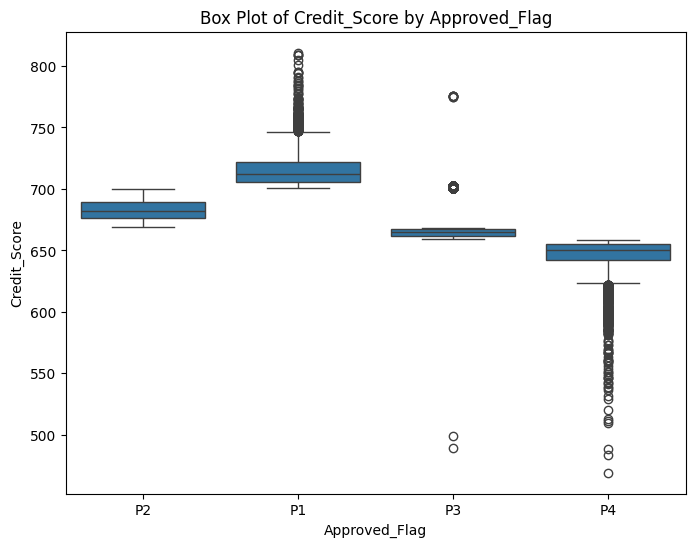

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Approved_Flag', y="Credit_Score", data=combined_df)
plt.title(f'Box Plot of {"Credit_Score"} by Approved_Flag')
plt.show()

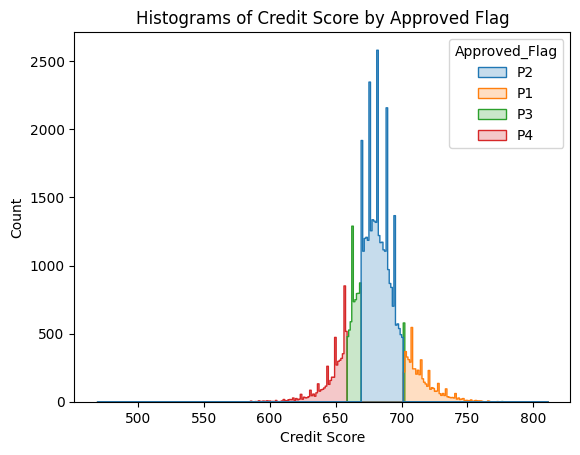

In [ ]:
sns.histplot(data=combined_df, x='Credit_Score', hue='Approved_Flag', element='step')

plt.title('Histograms of Credit Score by Approved Flag')
plt.xlabel('Credit Score')
plt.ylabel('Count')

plt.show()

In [ ]:
# Encode target variable
combined_df['Approved_Flag'] = combined_df['Approved_Flag'].map({'P1': 0, 'P2': 0, 'P3': 0, 'P4': 1})

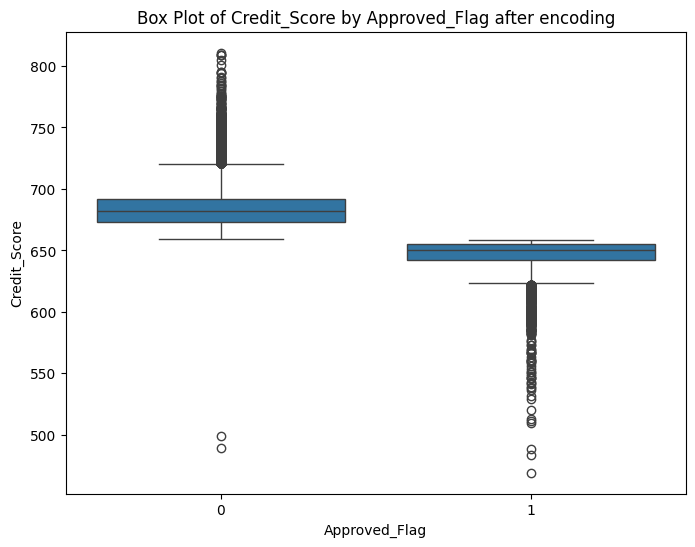

In [ ]:
# Boxplot after encoding
plt.figure(figsize=(8, 6))
sns.boxplot(x='Approved_Flag', y="Credit_Score", data=combined_df)
plt.title(f'Box Plot of {"Credit_Score"} by Approved_Flag after encoding')
plt.show()

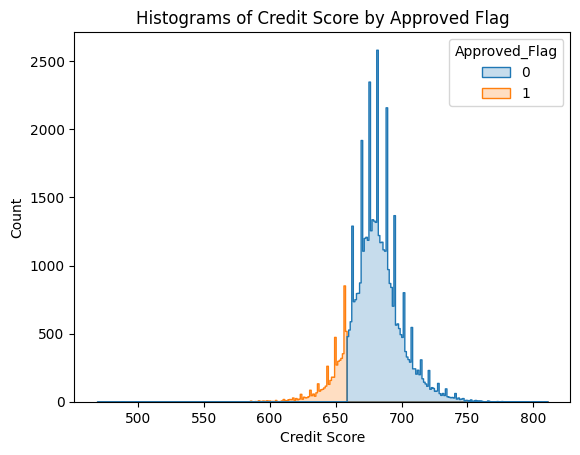

In [ ]:
# Histogram after encoding
sns.histplot(data=combined_df, x='Credit_Score', hue='Approved_Flag', element='step')

plt.title('Histograms of Credit Score by Approved Flag')
plt.xlabel('Credit Score')
plt.ylabel('Count')

plt.show()

**Minimal preporcessing with random forest**

In [ ]:
# Convert categorical variables using ohe

object_cols = combined_df.select_dtypes(include=['object']).columns
numeric_cols = combined_df.select_dtypes(exclude=['object']).columns.drop("Approved_Flag")

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, object_cols),
        ('num', 'passthrough', numeric_cols)
    ])

# Create the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [ ]:
X = combined_df.drop('Approved_Flag', axis=1)
y = combined_df['Approved_Flag']


param_dist = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': randint(10, 50),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(2, 10),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
random_search_minimal = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=5, cv=5, scoring='f1', random_state=42)

random_search_minimal.fit(X_train, y_train)

# Make predictions on the test set
y_pred_minimal = random_search_minimal.predict(X_test)



f1 for minimal processing: 1.0


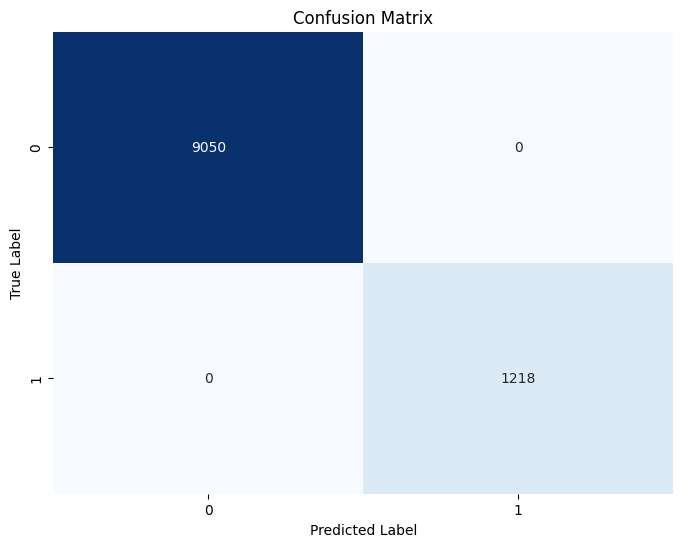

In [ ]:
# Evaluate the model
f1_minimal = f1_score(y_test, y_pred_minimal)
print(f"f1 for minimal processing: {f1_minimal}")

cm = confusion_matrix(y_test, y_pred_minimal)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
display(y_train.value_counts())
display(y_test.value_counts())


,count
Approved_Flag,
0,36404
1,4664


,count
Approved_Flag,
0,9050
1,1218


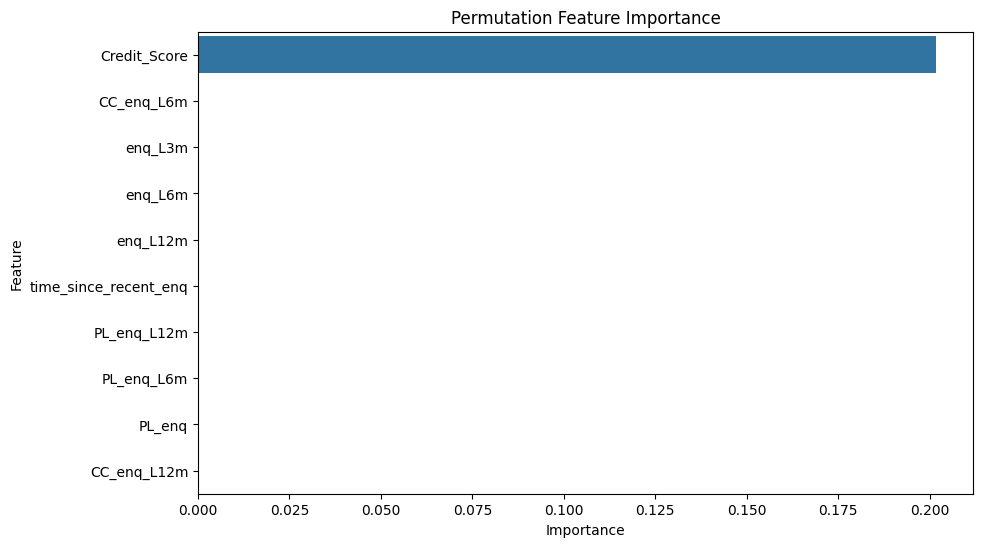

In [ ]:
# Feature importance
best_model = random_search_minimal.best_estimator_
best_params = random_search_minimal.best_params_
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': result.importances_mean})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Instead of binary, classify multi class**

In [ ]:
combined_df_multi = pd.merge(internal_df, externdal_df, on='PROSPECTID')

f1 for minimal processing: 0.9871445266848461


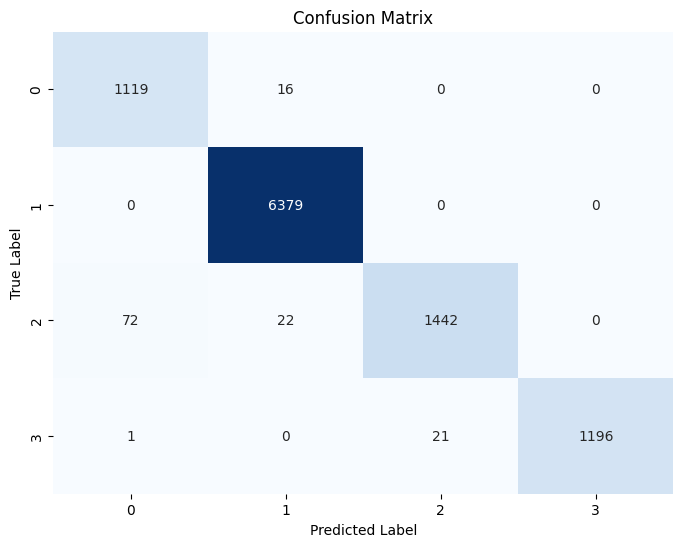

In [ ]:
# Convert categorical variables using ohe

object_cols_multi = combined_df_multi.select_dtypes(include=['object']).columns
numeric_cols_multi = combined_df_multi.select_dtypes(exclude=['object']).columns

X_multi = combined_df_multi.drop('Approved_Flag', axis=1)
y_multi = combined_df_multi['Approved_Flag']

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
random_search_minimal_multi = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=5, cv=5, scoring='f1_micro', random_state=42)

# Train the model
random_search_minimal_multi.fit(X_train_multi, y_train_multi)

# Make predictions on the test set
y_pred_minimal_multi = random_search_minimal_multi.predict(X_test_multi)

# Evaluate the model
f1_minimal_multi = f1_score(y_test_multi, y_pred_minimal_multi, average='micro')
print(f"f1 for minimal processing: {f1_minimal_multi}")

cm_multi = confusion_matrix(y_test_multi, y_pred_minimal_multi)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**Without credit score**

f1 for minimal processing: 0.696073679108095


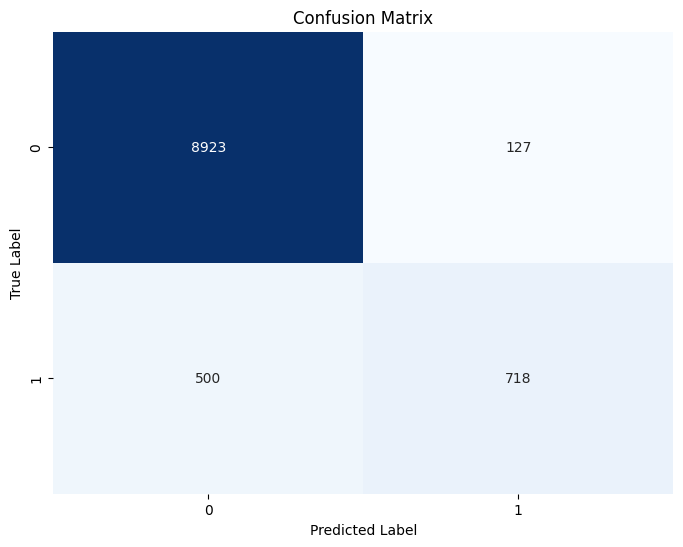

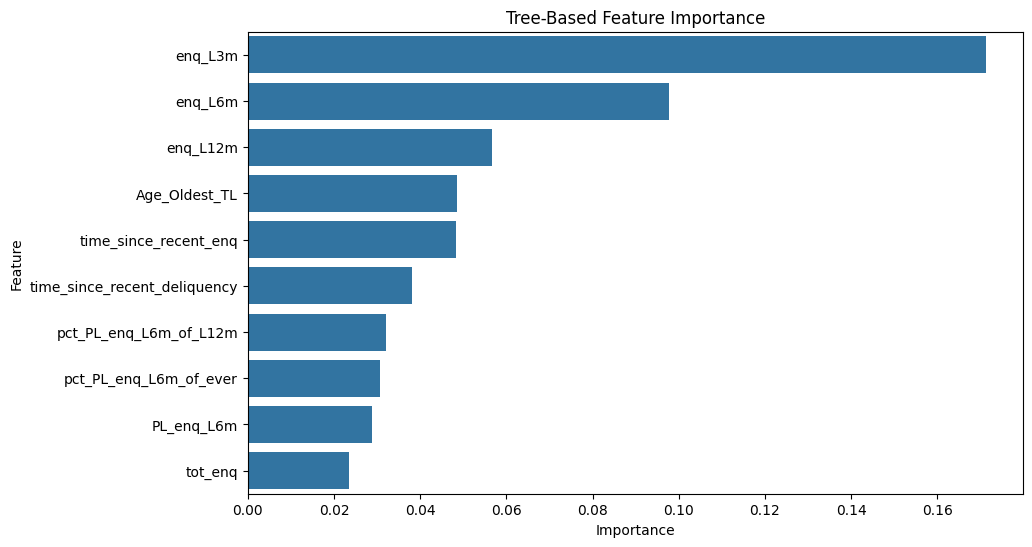

In [ ]:
# Convert categorical variables using ohe

object_cols_no_credit_score = combined_df.select_dtypes(include=['object']).columns
numeric_cols_no_credit_score = combined_df.select_dtypes(exclude=['object']).columns.drop(["Approved_Flag", "Credit_Score"])


preprocessor_no_credit_score = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, object_cols_no_credit_score),
        ('num', 'passthrough', numeric_cols_no_credit_score)
    ])

# Create the final pipeline
pipeline_no_credit_scor = Pipeline(steps=[
    ('preprocessor', preprocessor_no_credit_score),
    ("classifier", RandomForestClassifier(random_state=42))
])

X_no_credit_score = combined_df.drop(['Approved_Flag', "Credit_Score"], axis=1)
y_no_credit_score = combined_df['Approved_Flag']

X_train_no_credit_score, X_test_no_credit_score, y_train_no_credit_score, y_test_no_credit_score = train_test_split(X_no_credit_score, y_no_credit_score, test_size=0.2, random_state=42)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
random_search_minimal_no_credit_score = RandomizedSearchCV(estimator=pipeline_no_credit_scor, param_distributions=param_dist, n_iter=5, cv=5, scoring='f1', random_state=42)

# Train the model
random_search_minimal_no_credit_score.fit(X_train_no_credit_score, y_train_no_credit_score)

# Make predictions on the test set
y_pred_minimal_no_credit_score = random_search_minimal_no_credit_score.predict(X_test_no_credit_score)

# Evaluate the model
f1_minimal_no_credit_score = f1_score(y_test_no_credit_score, y_pred_minimal_no_credit_score)
print(f"f1 for minimal processing: {f1_minimal_no_credit_score}")

cm_no_credit_score = confusion_matrix(y_test_no_credit_score, y_pred_minimal_no_credit_score)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_no_credit_score, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# best_model_no_credit_score = random_search_minimal_no_credit_score.best_estimator_
# best_params_no_credit_score = random_search_minimal_no_credit_score.best_params_
# result_no_credit_score = permutation_importance(best_model_no_credit_score, X_test_no_credit_score, y_test_no_credit_score, n_repeats=10, random_state=42, n_jobs=-1)

# # Create a DataFrame to store feature importances
# feature_importance_df_no_credit_score = pd.DataFrame({'Feature': X_test_no_credit_score.columns, 'Importance': result_no_credit_score.importances_mean})
# feature_importance_df_no_credit_score = feature_importance_df_no_credit_score.sort_values(by='Importance', ascending=False)[:10]

# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=feature_importance_df_no_credit_score)
# plt.title('Permutation Feature Importance')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()

# After training the model, extract feature importances from the tree-based model
best_model_no_credit_score = random_search_minimal_no_credit_score.best_estimator_

# Extract the classifier from the pipeline
classifier = best_model_no_credit_score.named_steps['classifier']

# Get the feature importances from the RandomForestClassifier
feature_importances = classifier.feature_importances_

# Handle transformed feature names from the ColumnTransformer (one-hot encoded categories and numeric columns)
preprocessor = best_model_no_credit_score.named_steps['preprocessor']

# Get the transformed feature names from the preprocessor (one-hot encoded and numeric)
onehot_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(object_cols_no_credit_score)
all_feature_names = np.hstack([onehot_columns, numeric_cols_no_credit_score])

# Create a DataFrame to store feature importances
feature_importance_df_no_credit_score = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
feature_importance_df_no_credit_score = feature_importance_df_no_credit_score.sort_values(by='Importance', ascending=False)[:10]

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_no_credit_score)
plt.title('Tree-Based Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


**Preprocessing**

In [ ]:
proportion_missing = (combined_df == -99999).sum() / len(combined_df) * 100
columns_with_missing = proportion_missing[proportion_missing > 0]
print(columns_with_missing)

Age_Oldest_TL                    0.077918
Age_Newest_TL                    0.077918
time_since_recent_payment        8.358657
time_since_first_deliquency     70.026882
time_since_recent_deliquency    70.026882
max_delinquency_level           70.026882
max_deliq_6mts                  25.109085
max_deliq_12mts                 21.100203
tot_enq                         12.312997
CC_enq                          12.312997
CC_enq_L6m                      12.312997
CC_enq_L12m                     12.312997
PL_enq                          12.312997
PL_enq_L6m                      12.312997
PL_enq_L12m                     12.312997
time_since_recent_enq           12.312997
enq_L12m                        12.312997
enq_L6m                         12.312997
enq_L3m                         12.312997
pct_currentBal_all_TL            0.140252
CC_utilization                  92.792582
PL_utilization                  86.557192
max_unsec_exposure_inPct        45.149603
dtype: float64


In [ ]:
# Missing variables so either replace with None or impute by KNN
var_missing = ['tot_enq', 'CC_enq', 'CC_enq_L6m', 'CC_enq_L12m', 'PL_enq',
       'PL_enq_L6m', 'PL_enq_L12m', 'time_since_recent_enq', 'enq_L12m',
       'enq_L6m', 'enq_L3m']

# Vars that have no delinquency, so create an indicator variable and relace with None (indicator for one of time_since_first_deliquency or time_since_recent_deliquency is sufficient)
var_replece_none_and_dummy = ["time_since_first_deliquency", "time_since_recent_deliquency", "time_since_recent_payment"]

# Drop rows if these variables are missing as only few are missing
var_drop = ["Age_Oldest_TL", "Age_Newest_TL", "pct_currentBal_all_TL"]

# Vars to replace with None since, there is another indicator dummy variable (max_unsec_exposure_inPct doesn't have but another dummy but include here)
var_replace_none = ["CC_utilization", "PL_utilization", "max_unsec_exposure_inPct"]

In [ ]:
# Create function and drop some rows
combined_df_tree = combined_df.drop(["Credit_Score", "PROSPECTID"], axis=1)
combined_df = combined_df[~combined_df[var_drop].isin([-99999]).any(axis=1)]

# Function to create an indicator variable for -99999 in specified columns
def create_indicator_variable(df, columns):
    for col in columns:
        indicator_col = f'{col}_is_missing'
        df[indicator_col] = (df[col] == -99999).astype(int)
    return df

# Function to replace -99999 with None (NaN) in specified columns
def replace_99999_with_none(df, columns):
    df[columns] = df[columns].replace(-99999, np.NaN)
    return df

Functions

In [ ]:
# Function to create the preprocessor pipeline (KNN imputation optional)

class KNNImputerWithColumns(KNNImputer):
    def __init__(self, feature_columns=None, **kwargs):
        super().__init__(**kwargs)
        self.feature_columns = feature_columns

    def fit(self, X, y=None):
        return super().fit(X[self.feature_columns], y)

    def transform(self, X):
        imputed = super().transform(X[self.feature_columns])
        X[self.feature_columns] = imputed
        return X

def create_preprocessor(knn_impute_cols, knn_impute_feature_cols, object_cols, numeric_cols, use_knn=False):
    transformers = []

    # Conditionally apply KNN imputation if use_knn is True
    if use_knn:
        knn_imputer = Pipeline(steps=[
            ('knn_imputer', KNNImputerWithColumns(feature_columns=knn_impute_feature_cols, n_neighbors=5))
        ])
        transformers.append(('knn', knn_imputer, knn_impute_cols))

    # One-hot encode categorical features
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    transformers.append(('cat', categorical_transformer, object_cols))

    # Pass numerical features unchanged
    transformers.append(('num', 'passthrough', numeric_cols))

    preprocessor = ColumnTransformer(transformers)

    return preprocessor

# Function to create the full pipeline with classifier
def create_model_pipeline(preprocessor, classifier_type='random_forest'):
    if classifier_type == 'random_forest':
        classifier = RandomForestClassifier(random_state=42)
    elif classifier_type == 'xgboost':
        classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    return pipeline

# Function for hyperparameter tuning and training
def perform_randomized_search(pipeline, X_train, y_train, param_dist, n_iter=10, cv=5, scoring='f1', random_state=42):
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        random_state=random_state
    )
    random_search.fit(X_train, y_train)
    return random_search



# # Function to evaluate the model and show feature importance
# def evaluate_model(model, X_test, y_test, preprocessor, feature_names):
#     y_pred = model.predict(X_test)
#     f1 = f1_score(y_test, y_pred)
#     conf_matrix = confusion_matrix(y_test, y_pred)

#     print(f"F1: {f1}")
#     print("Confusion Matrix:")
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
#     plt.title('Confusion Matrix')
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.show()

#     # Permutation importance
#     result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='f1')

#     # Handle transformed feature names due to one-hot encoding
#     fitted_preprocessor = model.best_estimator_.named_steps['preprocessor']
#     transformed_feature_names = get_transformed_feature_names(fitted_preprocessor, feature_names)

#     # Sort the features by importance
#     sorted_idx = result.importances_mean.argsort()[::-1]

#     # Plot the permutation importances
#     plt.figure(figsize=(10, 8))
#     plt.barh(np.array(transformed_feature_names)[sorted_idx][:10], result.importances_mean[sorted_idx][:10])
#     plt.title("Permutation Feature Importance")
#     plt.xlabel("Importance")
#     plt.ylabel("Features")
#     plt.show()

#     df_importances = pd.DataFrame(list(zip(np.array(transformed_feature_names)[sorted_idx], result.importances_mean[sorted_idx])), columns=['Feature', 'Importance'])

#     return f1, conf_matrix, df_importances


# def evaluate_model(model, X_test, y_test, preprocessor=None, feature_names=None):
#     # Evaluate the model
#     y_pred = model.predict(X_test)
#     f1 = f1_score(y_test, y_pred)
#     conf_matrix = confusion_matrix(y_test, y_pred)

#     print(f"F1: {f1}")
#     print("Confusion Matrix:")
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
#     plt.title('Confusion Matrix')
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.show()

#     result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='f1')

#     # If preprocessor is not None, transform the feature names
#     if preprocessor is not None:
#         fitted_preprocessor = model.best_estimator_.named_steps['preprocessor']
#         transformed_feature_names = get_transformed_feature_names(fitted_preprocessor, feature_names)
#     else:
#         transformed_feature_names = feature_names  # Use original feature names

#     # If the model has coefficients (Logistic Regression)
#     if hasattr(model.best_estimator_.named_steps['classifier'], 'coef_'):
#         coefficients = model.best_estimator_.named_steps['classifier'].coef_[0]
#         coeff_df = pd.DataFrame({
#             'Feature': transformed_feature_names,
#             'Coefficient': coefficients
#         }).sort_values(by='Coefficient', key=abs, ascending=False)
#         display(coeff_df)

#     # Sort the features by importance
#     sorted_idx = result.importances_mean.argsort()[::-1]

#     # Plot the permutation importances
#     plt.figure(figsize=(10, 8))
#     plt.barh(np.array(transformed_feature_names)[sorted_idx][:10], result.importances_mean[sorted_idx][:10])
#     plt.title("Permutation Feature Importance")
#     plt.xlabel("Importance")
#     plt.ylabel("Features")
#     plt.show()

#     df_importances = pd.DataFrame(list(zip(np.array(transformed_feature_names)[sorted_idx], result.importances_mean[sorted_idx])), columns=['Feature', 'Importance'])

#     return f1, conf_matrix, df_importances

def evaluate_model(model, X_test, y_test, preprocessor=None, feature_names=None):
    # Evaluate the model
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"F1: {f1}")
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Tree-based feature importance
    best_model = model.best_estimator_
    classifier = best_model.named_steps['classifier']

    if hasattr(classifier, 'feature_importances_'):
        feature_importances = classifier.feature_importances_

        # If preprocessor is not None, transform the feature names
        if preprocessor is not None:
            fitted_preprocessor = model.best_estimator_.named_steps['preprocessor']
            transformed_feature_names = get_transformed_feature_names(fitted_preprocessor, feature_names)
        else:
            transformed_feature_names = feature_names  # Use original feature names

        # Create a DataFrame to store feature importances
        feature_importance_df = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_importances})

        # Plot feature importances
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False))
        plt.title('Tree-Based Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()
    else:
        print("The classifier does not support feature importances.")
        feature_importance_df = None

    return f1, conf_matrix, feature_importance_df


# Function to get transformed feature names (handling one-hot encoding)
def get_transformed_feature_names(preprocessor, original_feature_names):
    transformed_feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'cat':
            if hasattr(transformer.named_steps['onehot'], 'get_feature_names_out'):
                cat_feature_names = transformer.named_steps['onehot'].get_feature_names_out(columns)
                transformed_feature_names.extend(cat_feature_names)
            else:
                transformed_feature_names.extend(columns)

        elif name == 'num':
            transformed_feature_names.extend(columns)

        elif name == 'knn':
            transformed_feature_names.extend(columns)

    return transformed_feature_names

# Main function to run the pipeline with optional KNN and selected classifier
def run_pipeline(combined_df, target_column='Approved_Flag', classifier_type='random_forest', use_knn=False, use_train_for_eval=False):
    # Split data into features (X) and target (y) early to prevent data leakage
    X = combined_df.drop(target_column, axis=1)
    y = combined_df[target_column]

    # Identify column types
    knn_impute_cols = var_missing
    knn_impute_feature_cols = combined_df.columns.difference(knn_impute_cols).drop(target_column).to_list()
    object_cols = X.select_dtypes(include=['object']).columns
    numeric_cols = X.select_dtypes(exclude=['object']).columns

    # Split the data before preprocessing to avoid data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if use_knn:
        print("Applying KNN imputation...")
        knn_imputer = KNNImputer(n_neighbors=5)
        X_train[knn_impute_cols] = knn_imputer.fit_transform(X_train[knn_impute_cols])
        X_test[knn_impute_cols] = knn_imputer.transform(X_test[knn_impute_cols])

        proportion_missing = (combined_df == -99999).sum() / len(combined_df) * 100
        columns_with_missing = proportion_missing[proportion_missing > 0]
        print(columns_with_missing)


    # Create preprocessor with optional KNN imputation
    preprocessor = create_preprocessor(knn_impute_cols, knn_impute_feature_cols, object_cols, numeric_cols)

    # Create pipeline with preprocessor and selected classifier
    pipeline = create_model_pipeline(preprocessor, classifier_type=classifier_type)

    # Define hyperparameter search space based on the classifier type
    if classifier_type == 'random_forest':
        param_dist = {
            'classifier__n_estimators': randint(50, 200),
            'classifier__max_depth': [None, 10, 20, 30, 40, 50],
            'classifier__min_samples_split': randint(2, 20),
            'classifier__min_samples_leaf': randint(1, 10)
        }
    elif classifier_type == 'xgboost':
        param_dist = {
            'classifier__n_estimators': randint(50, 200),
            'classifier__max_depth': randint(3, 10),
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__subsample': [0.6, 0.8, 1.0]
        }

    # Perform hyperparameter tuning and model training
    best_model = perform_randomized_search(pipeline, X_train, y_train, param_dist)

    # Evaluate the best model and show feature importance
    if not use_train_for_eval:
      f1, conf_matrix, feature_imp = evaluate_model(best_model, X_test, y_test, preprocessor, combined_df.drop(target_column, axis=1))
    else:
      f1, conf_matrix, feature_imp = evaluate_model(best_model, X_train, y_train, preprocessor, combined_df.drop(target_column, axis=1))
        # if inportant_features:
    #     best_model = perform_randomized_search(pipeline, X_train[feature_imp], y_train, param_dist)
    return best_model, f1, conf_matrix, feature_imp

# Example usage:
# To run with Random Forest and KNN imputation
# run_pipeline(combined_df, classifier_type='random_forest', use_knn=True)

# To run with XGBoost without KNN imputation
# run_pipeline(combined_df, classifier_type='xgboost', use_knn=False)


*Combined_df_tree_1: indicator variables only for var_replece_none_and_dummy*

In [ ]:
# No imputation, just replace with None
combined_df_tree_1 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy)
combined_df_tree_1 = replace_99999_with_none(combined_df_tree_1, var_missing+var_replace_none+var_replece_none_and_dummy)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

F1: 0.6964112512124151
Confusion Matrix:


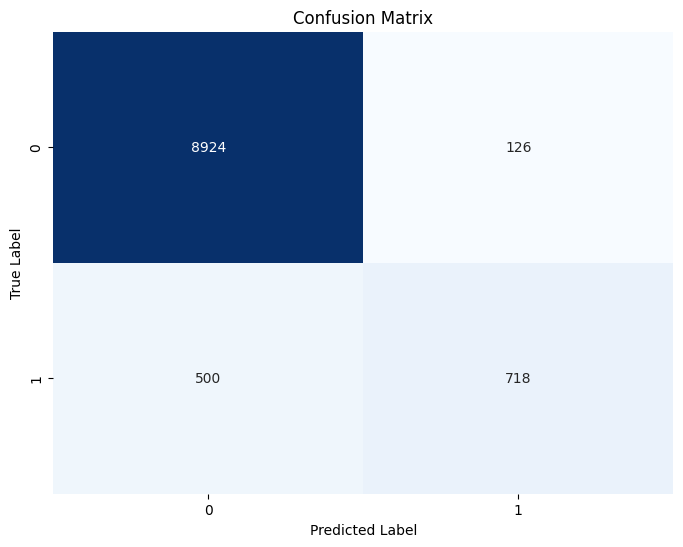

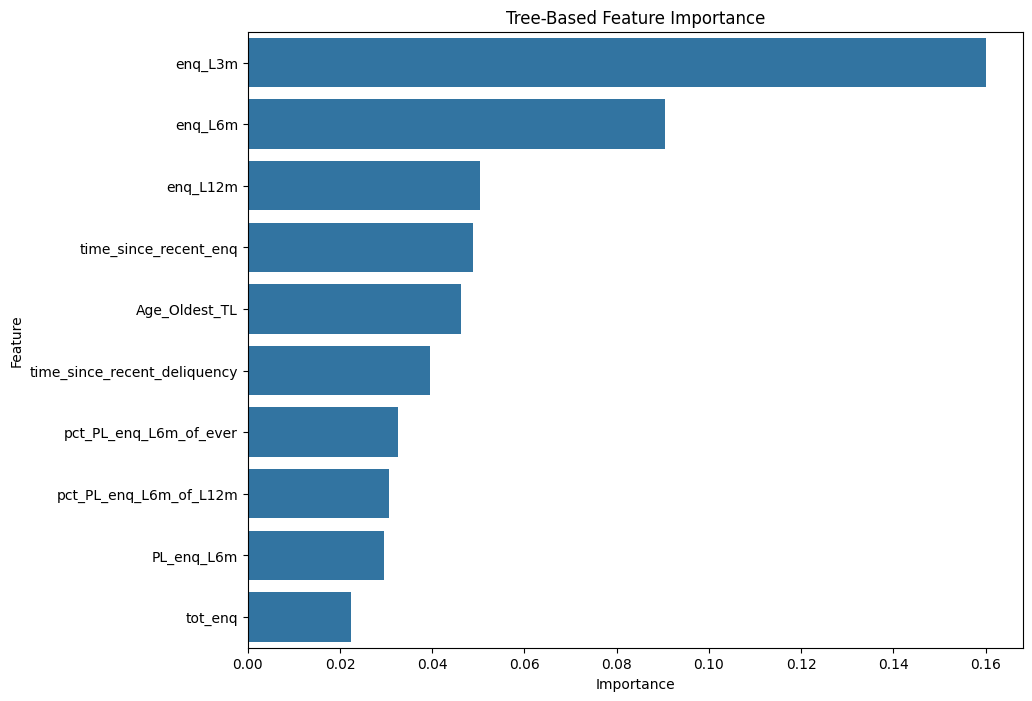

(RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                Index(['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2',
        'first_prod_enq2'],
       dtype='object')),
                                                                               ('num',
                                                                                'passthrough',
                                                                 

In [ ]:
# Random forest no imputation
combined_df_tree_1 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy)
combined_df_tree_1 = replace_99999_with_none(combined_df_tree_1, var_missing+var_replace_none+var_replece_none_and_dummy)
run_pipeline(combined_df_tree_1, classifier_type='random_forest', use_knn=False)

F1: 0.7583774250440917
Confusion Matrix:


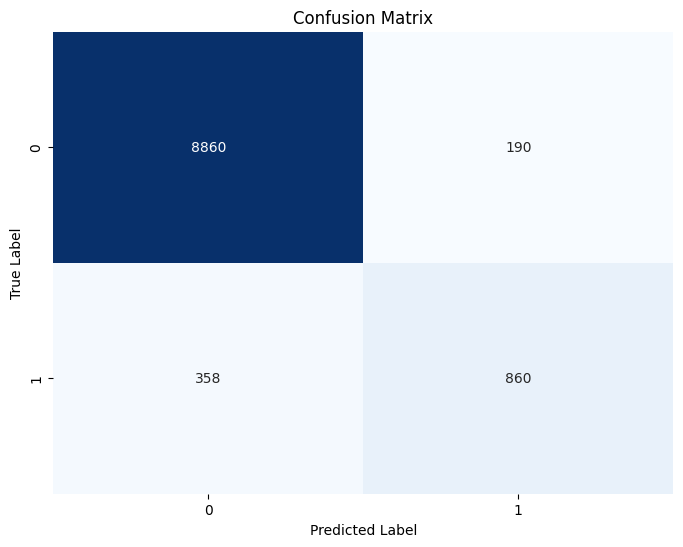

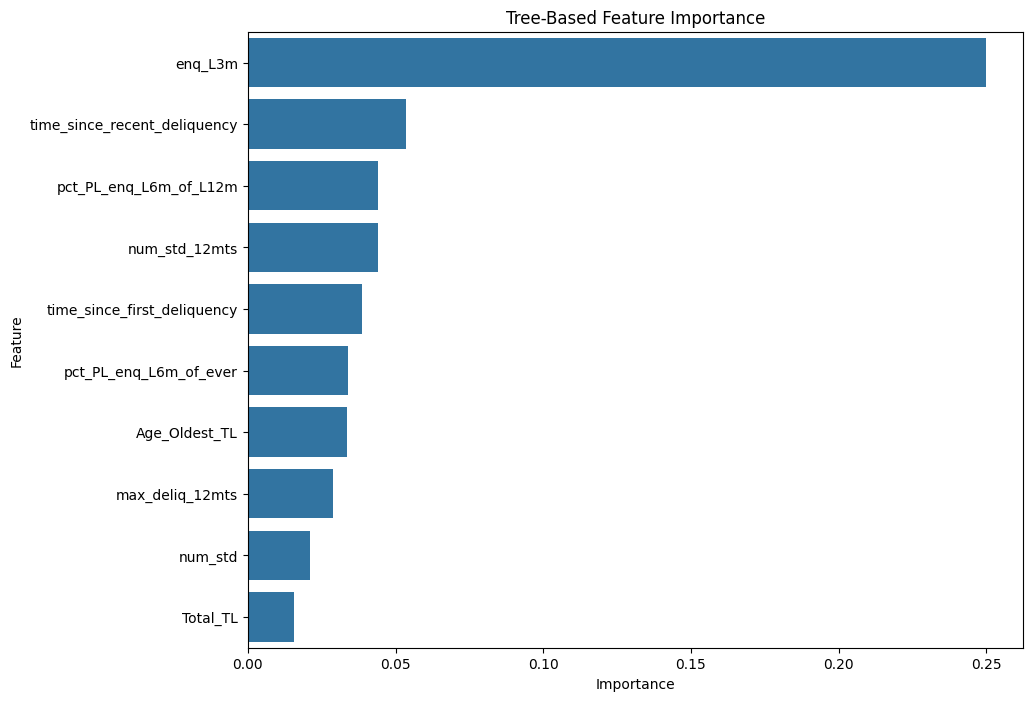

(RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                Index(['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2',
        'first_prod_enq2'],
       dtype='object')),
                                                                               ('num',
                                                                                'passthrough',
                                                                 

In [ ]:
# XGBoost no imputation
combined_df_tree_1 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy)
combined_df_tree_1 = replace_99999_with_none(combined_df_tree_1, var_missing+var_replace_none+var_replece_none_and_dummy)
run_pipeline(combined_df_tree_1, classifier_type='xgboost', use_knn=False)

Applying KNN imputation...
Age_Oldest_TL             0.077918
Age_Newest_TL             0.077918
max_delinquency_level    70.026882
max_deliq_6mts           25.109085
max_deliq_12mts          21.100203
pct_currentBal_all_TL     0.140252
dtype: float64
F1: 0.705825710158883
Confusion Matrix:


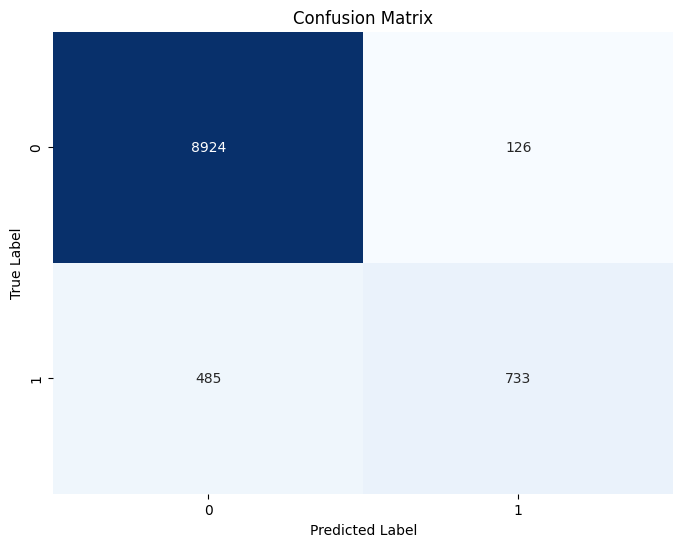

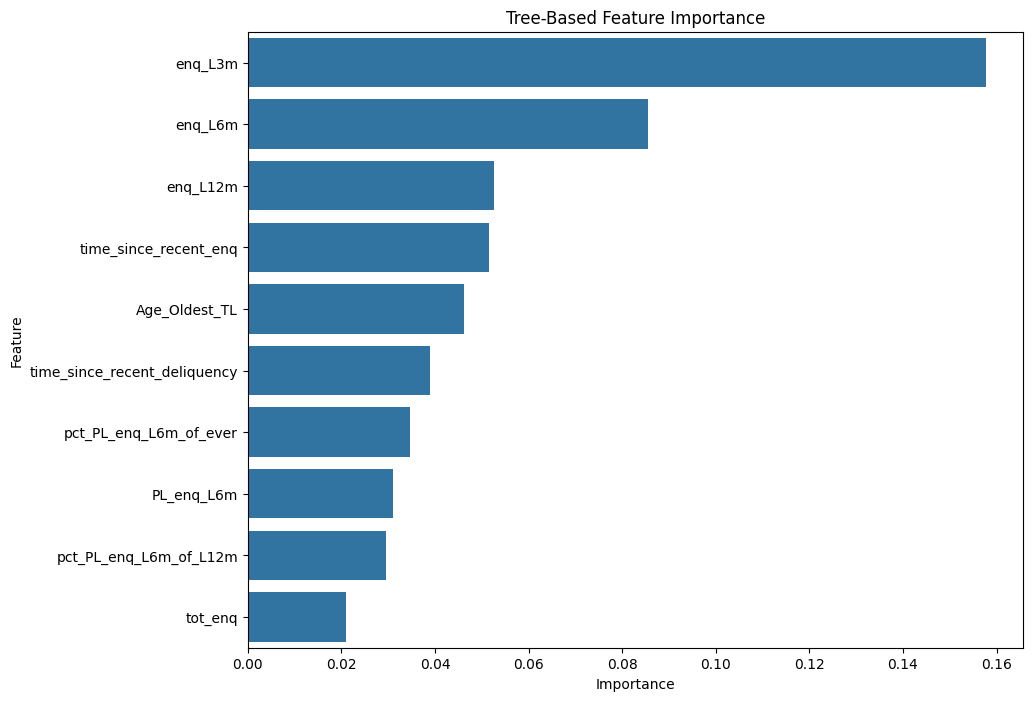

(RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                Index(['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2',
        'first_prod_enq2'],
       dtype='object')),
                                                                               ('num',
                                                                                'passthrough',
                                                                 

In [ ]:
# Random forest with imputation
combined_df_tree_1 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy)
combined_df_tree_1 = replace_99999_with_none(combined_df_tree_1, var_missing+var_replace_none+var_replece_none_and_dummy)
run_pipeline(combined_df_tree_1, classifier_type='random_forest', use_knn=True)

Applying KNN imputation...
Age_Oldest_TL             0.077918
Age_Newest_TL             0.077918
max_delinquency_level    70.026882
max_deliq_6mts           25.109085
max_deliq_12mts          21.100203
pct_currentBal_all_TL     0.140252
dtype: float64
F1: 0.7566137566137566
Confusion Matrix:


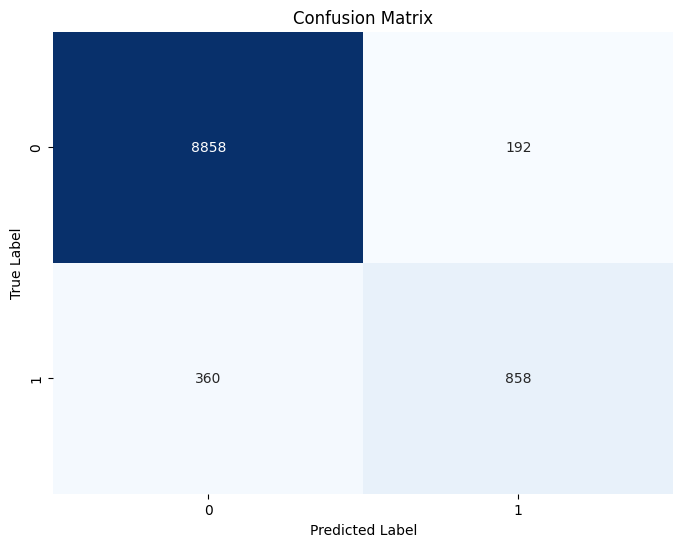

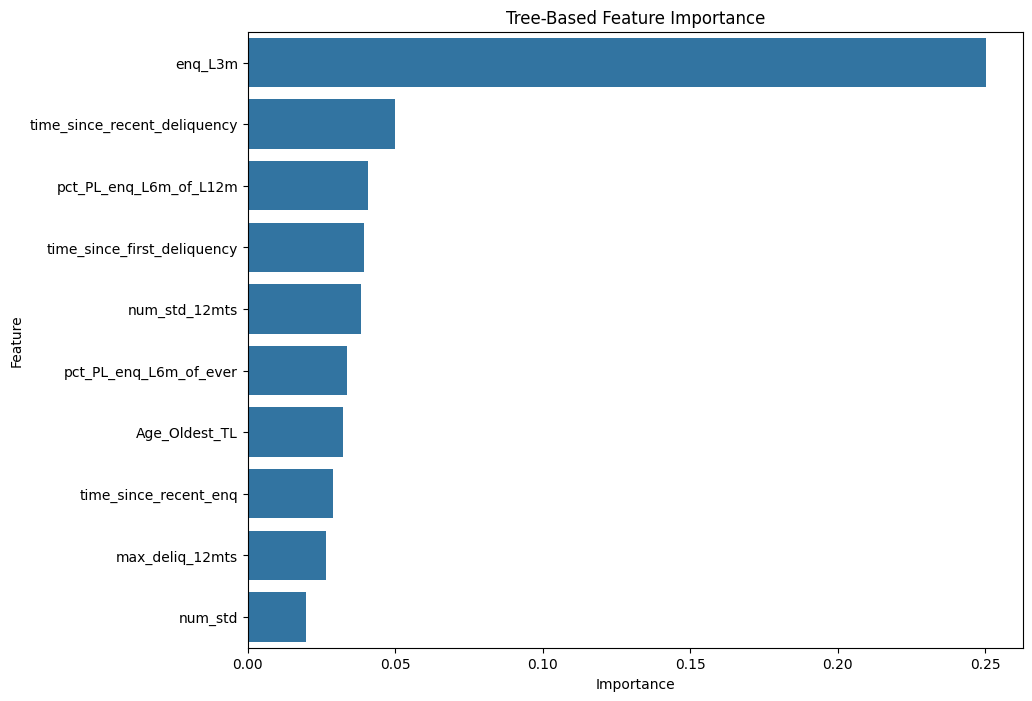

(RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                Index(['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2',
        'first_prod_enq2'],
       dtype='object')),
                                                                               ('num',
                                                                                'passthrough',
                                                                 

In [ ]:
# XGBoost with imputation
combined_df_tree_1 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy)
combined_df_tree_1 = replace_99999_with_none(combined_df_tree_1, var_missing+var_replace_none+var_replece_none_and_dummy)
run_pipeline(combined_df_tree_1, classifier_type='xgboost', use_knn=True)

*Combined_df_tree_2: indicator variables only for var_replece_none_and_dummy and tot_enq*


In [ ]:
combined_df_tree_2 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy+["tot_enq"])
combined_df_tree_2 = replace_99999_with_none(combined_df_tree_2, var_missing+var_replace_none+var_replece_none_and_dummy)

F1: 0.7002881844380403
Confusion Matrix:


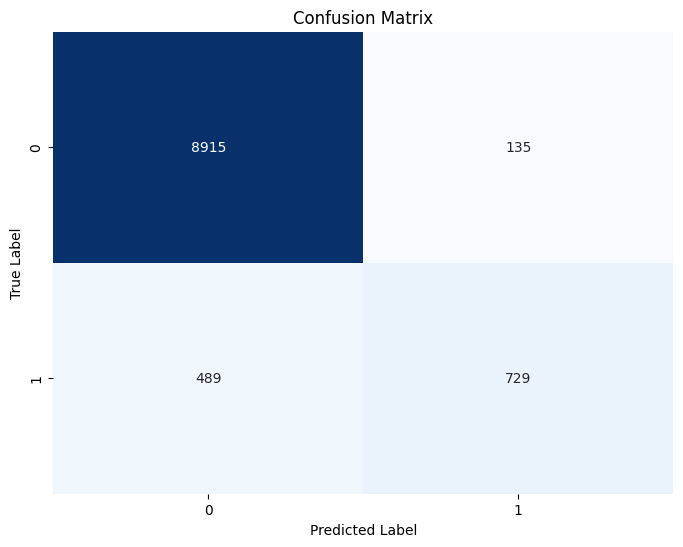

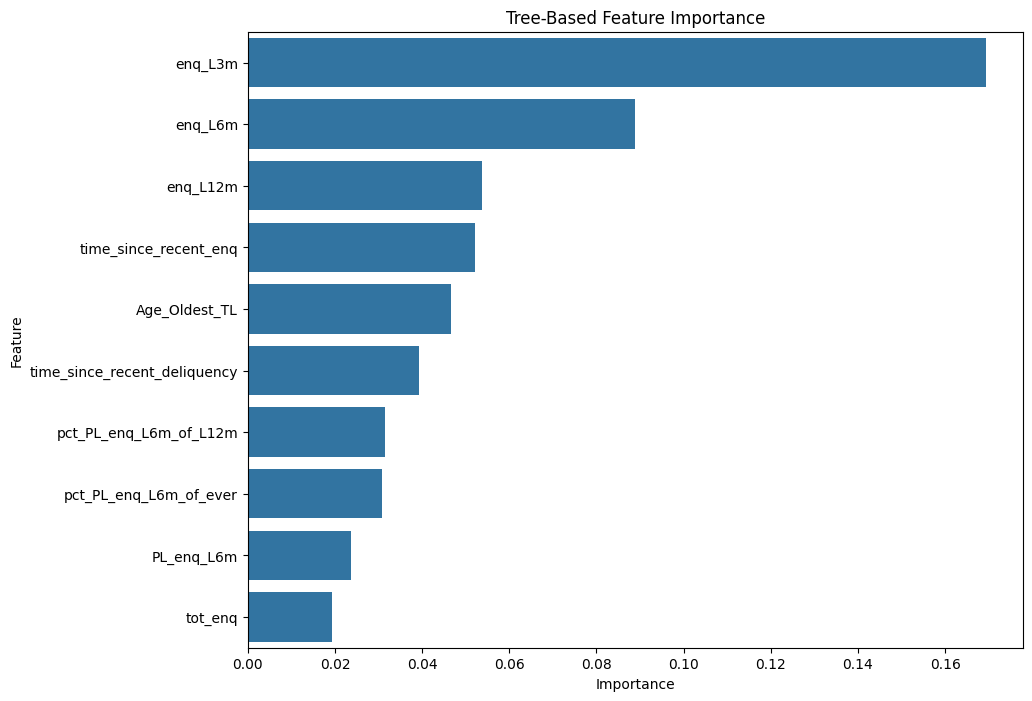

(RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                Index(['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2',
        'first_prod_enq2'],
       dtype='object')),
                                                                               ('num',
                                                                                'passthrough',
                                                                 

In [ ]:
# Random forest without imputation
combined_df_tree_2 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy+["tot_enq"])
combined_df_tree_2 = replace_99999_with_none(combined_df_tree_2, var_missing+var_replace_none+var_replece_none_and_dummy)
run_pipeline(combined_df_tree_2, classifier_type='random_forest', use_knn=False)

F1: 0.7583774250440917
Confusion Matrix:


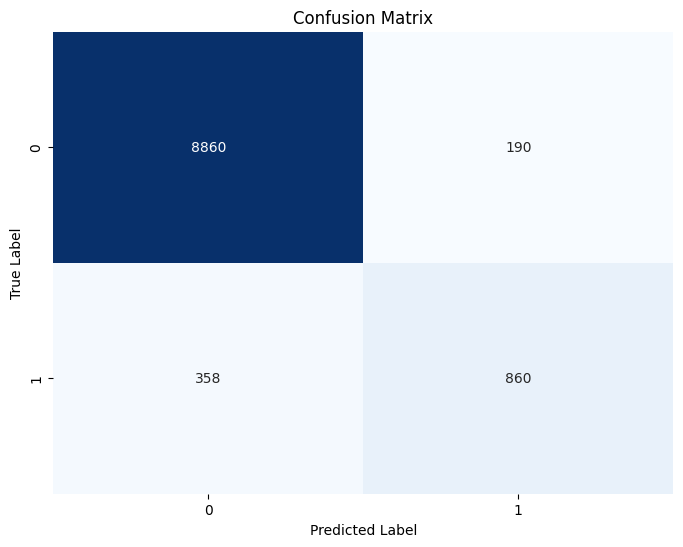

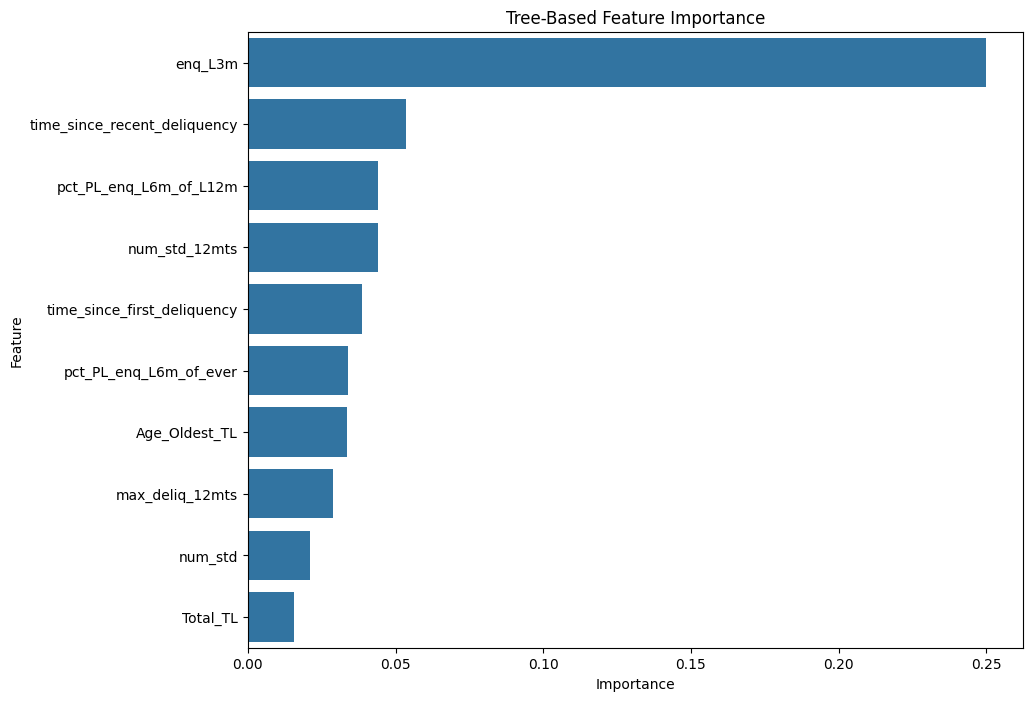

(RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                Index(['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2',
        'first_prod_enq2'],
       dtype='object')),
                                                                               ('num',
                                                                                'passthrough',
                                                                 

In [ ]:
# XGboost without imputation
combined_df_tree_2 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy+["tot_enq"])
combined_df_tree_2 = replace_99999_with_none(combined_df_tree_2, var_missing+var_replace_none+var_replece_none_and_dummy)
run_pipeline(combined_df_tree_2, classifier_type='xgboost', use_knn=False)

Applying KNN imputation...
Age_Oldest_TL             0.077918
Age_Newest_TL             0.077918
max_delinquency_level    70.026882
max_deliq_6mts           25.109085
max_deliq_12mts          21.100203
pct_currentBal_all_TL     0.140252
dtype: float64
F1: 0.6983213429256595
Confusion Matrix:


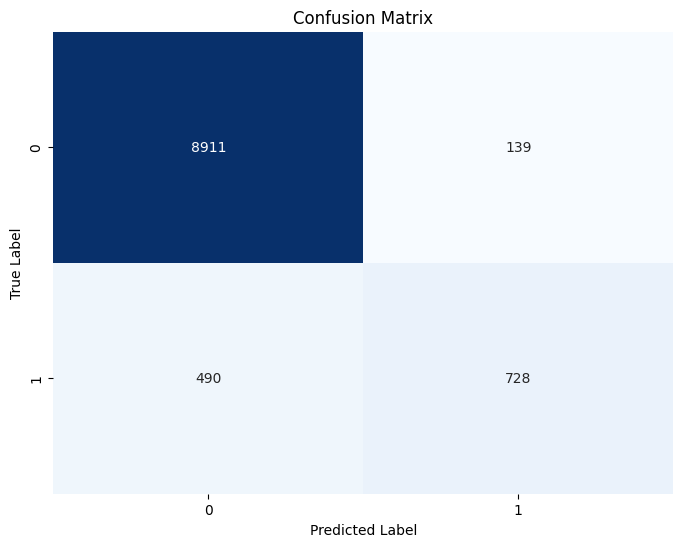

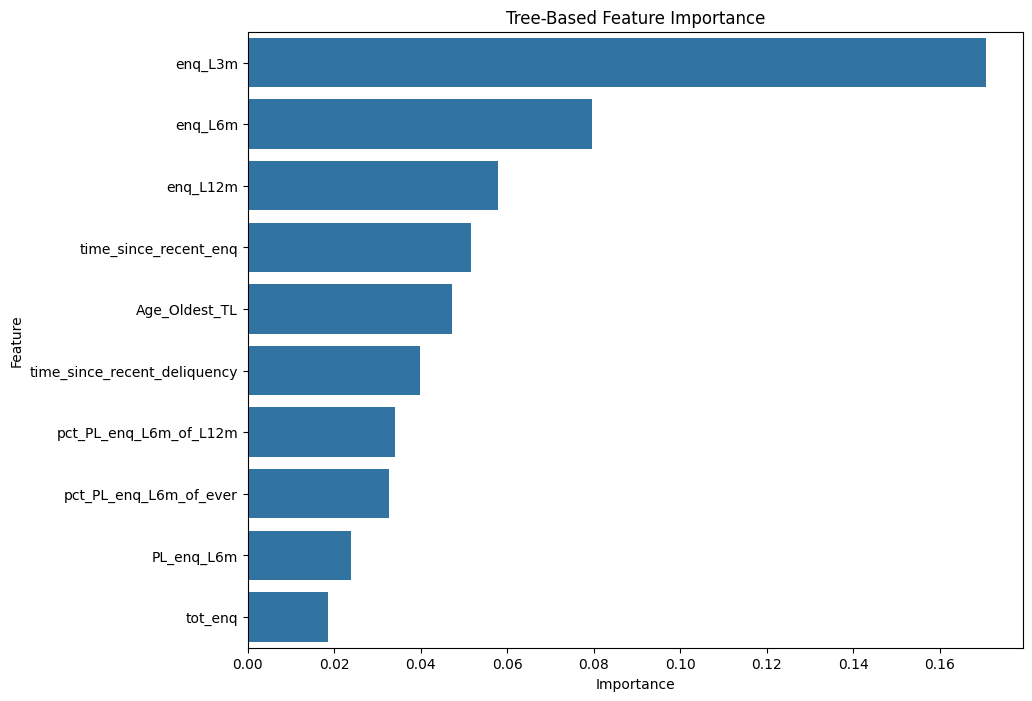

(RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                Index(['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2',
        'first_prod_enq2'],
       dtype='object')),
                                                                               ('num',
                                                                                'passthrough',
                                                                 

In [ ]:
# Random forest with imputation
combined_df_tree_2 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy+["tot_enq"])
combined_df_tree_2 = replace_99999_with_none(combined_df_tree_2, var_missing+var_replace_none+var_replece_none_and_dummy)
run_pipeline(combined_df_tree_2, classifier_type='random_forest', use_knn=True)

Applying KNN imputation...
Age_Oldest_TL             0.077918
Age_Newest_TL             0.077918
max_delinquency_level    70.026882
max_deliq_6mts           25.109085
max_deliq_12mts          21.100203
pct_currentBal_all_TL     0.140252
dtype: float64
F1: 0.7566137566137566
Confusion Matrix:


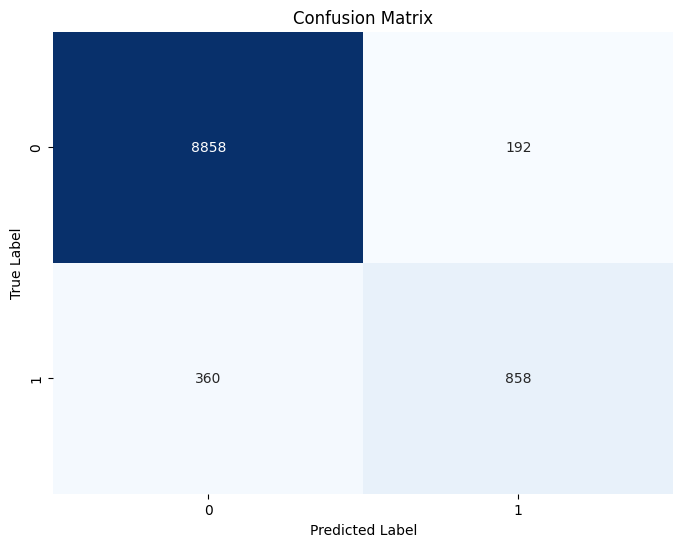

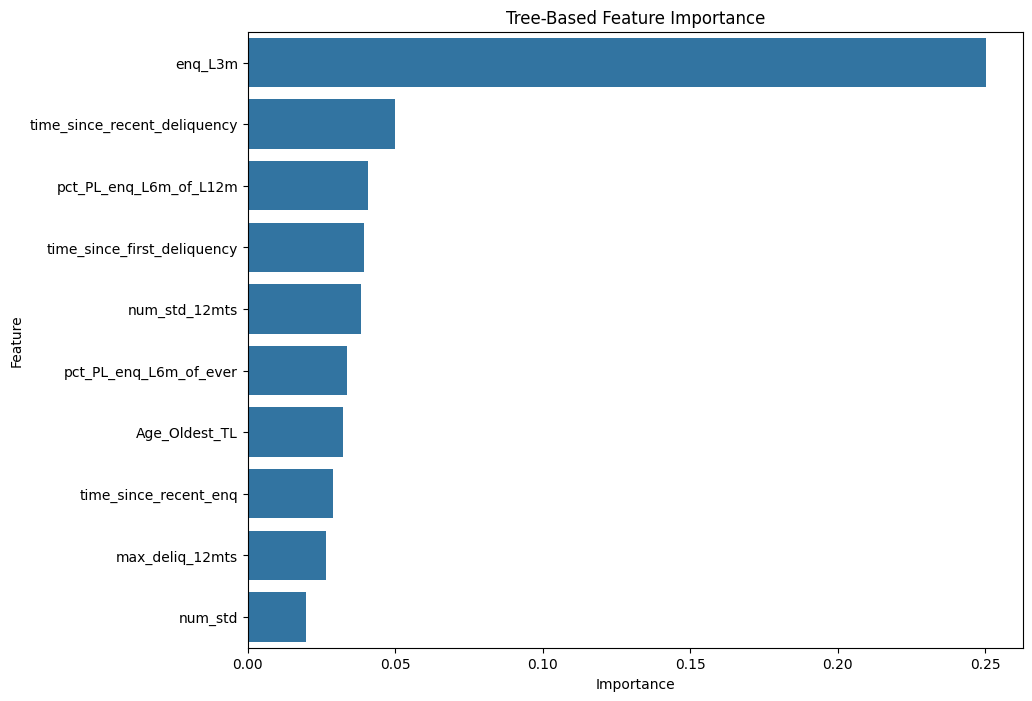

(RandomizedSearchCV(cv=5,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                Index(['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2',
        'first_prod_enq2'],
       dtype='object')),
                                                                               ('num',
                                                                                'passthrough',
                                                                 

In [ ]:
# XGboost with imputation
combined_df_tree_2 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy+["tot_enq"])
combined_df_tree_2 = replace_99999_with_none(combined_df_tree_2, var_missing+var_replace_none+var_replece_none_and_dummy)
run_pipeline(combined_df_tree_2, classifier_type='xgboost', use_knn=True)

**Feature Engineering**

In [ ]:
# Feature enginnering

def create_combined_variable(df, col1, col2, operation='add', new_col_name=None):
    if new_col_name is None:
        new_col_name = f'{col1}_{operation}_{col2}'

    # Define operations
    if operation == 'add':
        df[new_col_name] = df[col1] + df[col2]
    elif operation == 'subtract':
        df[new_col_name] = df[col1] - df[col2]
    elif operation == 'multiply':
        df[new_col_name] = df[col1] * df[col2]
    elif operation == 'divide':
        df[new_col_name] = df[col1] / df[col2].replace(0, pd.NA)  # Avoid division by zero
    else:
        raise ValueError("Invalid operation. Choose from 'add', 'subtract', 'multiply', or 'divide'.")

    return df

new_features = [
    ['Total_TL_opened_L6M', 'Total_TL', 'divide'],
    ['Tot_TL_closed_L6M', 'Tot_Closed_TL', 'divide'],
    ['Total_TL_opened_L12M', 'Total_TL', 'divide'],
    ['Tot_TL_closed_L12M', 'Tot_Closed_TL', 'divide'],
    ['Tot_Missed_Pmnt', 'Total_TL', 'divide'],
    ['Secured_TL', 'Unsecured_TL', 'divide'],
    ['CC_TL', 'Auto_TL', 'divide'],
    ['PL_TL', 'Home_TL', 'divide'],
    ['Age_Oldest_TL', 'Age_Newest_TL', 'subtract'],
    ['CC_TL', 'Total_TL', 'divide'],
    ['Auto_TL', 'Total_TL', 'divide'],
    ['Home_TL', 'Total_TL', 'divide'],
    ['PL_TL', 'Total_TL', 'divide'],
    ['Total_TL_opened_L6M', 'Total_TL_opened_L12M', 'divide'],
    ['Tot_TL_closed_L6M', 'Tot_TL_closed_L12M', 'divide'],
    ['Consumer_TL', 'Total_TL', 'divide'],
    ['Other_TL', 'Total_TL', 'divide'],
    ['Tot_Missed_Pmnt', 'Secured_TL', 'divide'],
    ['num_deliq_6mts', 'num_deliq_12mts', 'divide'],
    ['num_sub_6mts', 'num_sub_12mts', 'divide'],
    ['num_dbt_6mts', 'num_dbt_12mts', 'divide'],
    ['num_lss_6mts', 'num_lss_12mts', 'divide'],
    ['num_std_6mts', 'num_std_12mts', 'divide'],
    ['num_times_30p_dpd', 'num_times_delinquent', 'divide'],
    ['num_times_60p_dpd', 'num_times_delinquent', 'divide'],
    ['PL_utilization', 'CC_utilization', 'divide'],
    ['PL_enq_L6m', 'PL_enq_L12m', 'subtract'],
    ['CC_enq_L6m', 'CC_enq_L12m', 'subtract'],
    ['enq_L3m', 'enq_L6m', 'divide'],
    ['enq_L6m', 'enq_L12m', 'divide'],
    ['max_deliq_6mts', 'max_deliq_12mts', 'divide'],
    ['recent_level_of_deliq', 'max_delinquency_level', 'divide'],
    ['num_times_delinquent', 'tot_enq', 'divide'],
]



In [ ]:
combined_df_tree_1 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy)
combined_df_tree_1 = replace_99999_with_none(combined_df_tree_1, var_missing+var_replace_none+var_replece_none_and_dummy)

combined_df_tree_3 = combined_df_tree_1.copy()
for feature in new_features:
    combined_df_tree_3 = create_combined_variable(combined_df_tree_3, *feature)
combined_df_tree_3 = combined_df_tree_3.replace(pd.NA, np.NaN)

<ipython-input-14-6df60717d79e>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df_tree_3 = combined_df_tree_3.replace(pd.NA, np.NaN)


Applying KNN imputation...
Age_Oldest_TL                             0.077918
Age_Newest_TL                             0.077918
max_delinquency_level                    70.026882
max_deliq_6mts                           25.109085
max_deliq_12mts                          21.100203
pct_currentBal_all_TL                     0.140252
max_deliq_6mts_divide_max_deliq_12mts     0.038959
dtype: float64
F1: 0.8970299318155553
Confusion Matrix:


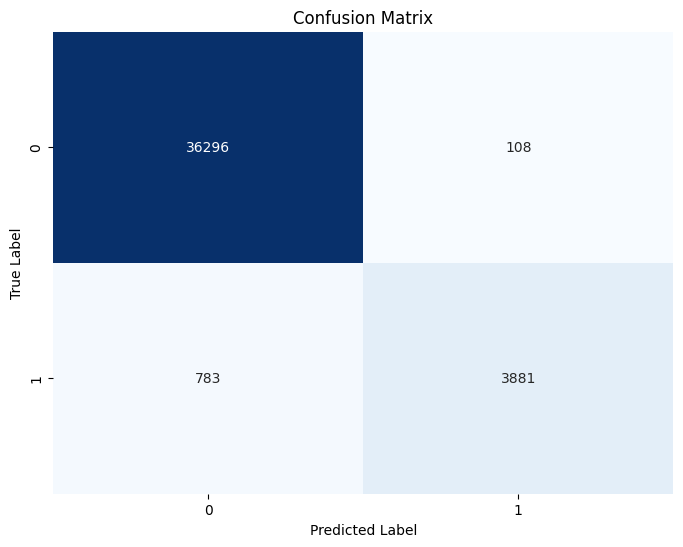

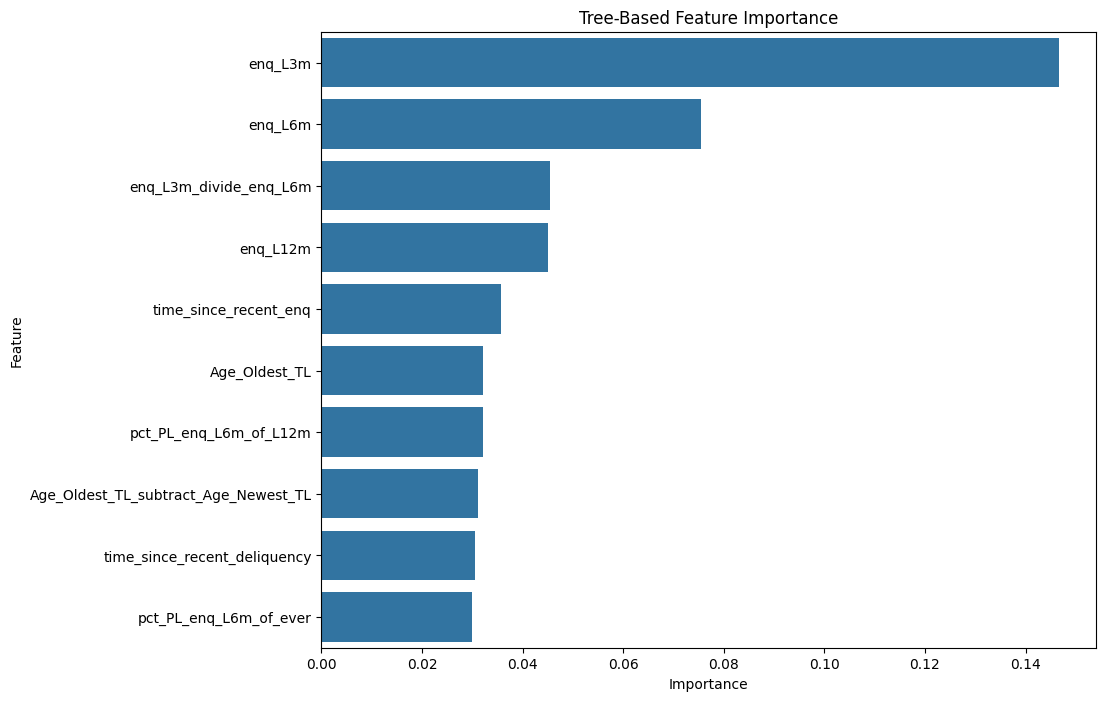

In [ ]:
# Identify noisy features
best_model, f1, conf_matrix, feature_imp = run_pipeline(combined_df_tree_3, classifier_type='random_forest', use_knn=True, use_train_for_eval=True)

In [ ]:
important_features = feature_imp[feature_imp['Importance'] > 0]['Feature'].tolist()

In [ ]:
combined_df_tree_1 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy)
combined_df_tree_1 = replace_99999_with_none(combined_df_tree_1, var_missing+var_replace_none+var_replece_none_and_dummy)

combined_df_tree_3 = combined_df_tree_1.copy()
for feature in new_features:
    combined_df_tree_3 = create_combined_variable(combined_df_tree_3, *feature)
combined_df_tree_3 = combined_df_tree_3.replace(pd.NA, np.NaN)
best_model, f1, conf_matrix, feature_imp = run_pipeline(combined_df_tree_3, classifier_type='random_forest', use_knn=True)

<ipython-input-17-e70f443ce090>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df_tree_3 = combined_df_tree_3.replace(pd.NA, np.NaN)


Applying KNN imputation...
Age_Oldest_TL                             0.077918
Age_Newest_TL                             0.077918
max_delinquency_level                    70.026882
max_deliq_6mts                           25.109085
max_deliq_12mts                          21.100203
pct_currentBal_all_TL                     0.140252
max_deliq_6mts_divide_max_deliq_12mts     0.038959
dtype: float64


KeyboardInterrupt: 

**For tree based**

In [ ]:
combined_df_tree_1 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy)
combined_df_tree_1 = replace_99999_with_none(combined_df_tree_1, var_missing+var_replace_none+var_replece_none_and_dummy)

combined_df_tree_3 = combined_df_tree_1.copy()
for feature in new_features:
    combined_df_tree_3 = create_combined_variable(combined_df_tree_3, *feature)
combined_df_tree_3 = combined_df_tree_3.replace(pd.NA, np.NaN)

df = combined_df_tree_3.copy()
# Train, test split
target_column = 'Approved_Flag'
X = df.drop(target_column, axis=1)
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_imputer = KNNImputer(n_neighbors=5)

X_train[var_missing] = knn_imputer.fit_transform(X_train[var_missing])
X_test[var_missing] = knn_imputer.transform(X_test[var_missing])

X_train_before_ohe = X_train.copy()
X_test_before_ohe = X_test.copy()

categorical_cols = X_train.select_dtypes(include=['object']).columns.to_list()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_encoded = pd.DataFrame(ohe.fit_transform(X_train[categorical_cols]), columns=ohe.get_feature_names_out(categorical_cols))
X_test_encoded = pd.DataFrame(ohe.transform(X_test[categorical_cols]), columns=ohe.get_feature_names_out(categorical_cols))

X_train = X_train.drop(categorical_cols, axis=1).reset_index(drop=True)
X_test = X_test.drop(categorical_cols, axis=1).reset_index(drop=True)

X_train_tree = pd.concat([X_train, X_train_encoded], axis=1)
X_test_tree = pd.concat([X_test, X_test_encoded], axis=1)


<ipython-input-30-7137ae9398b2>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df_tree_3 = combined_df_tree_3.replace(pd.NA, np.NaN)


In [ ]:
# Instead of one hot encoding, use label encoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Assuming the functions `create_indicator_variable`, `replace_99999_with_none`, and `create_combined_variable` are defined

# Step 1: Prepare the combined dataframe
combined_df_tree_1 = create_indicator_variable(combined_df_tree, var_replece_none_and_dummy)
combined_df_tree_1 = replace_99999_with_none(combined_df_tree_1, var_missing + var_replace_none + var_replece_none_and_dummy)

combined_df_tree_3 = combined_df_tree_1.copy()
for feature in new_features:
    combined_df_tree_3 = create_combined_variable(combined_df_tree_3, *feature)
combined_df_tree_3 = combined_df_tree_3.replace(pd.NA, np.NaN)

df = combined_df_tree_3.copy()

# Train-test split
target_column = 'Approved_Flag'
X = df.drop(target_column, axis=1)
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Impute missing values
knn_imputer = KNNImputer(n_neighbors=5)
X_train[var_missing] = knn_imputer.fit_transform(X_train[var_missing])
X_test[var_missing] = knn_imputer.transform(X_test[var_missing])

# Step 3: Encode categorical columns using LabelEncoder and save mappings
X_train_label = X_train.copy()
X_test_label = X_test.copy()

categorical_cols = X_train.select_dtypes(include=['object']).columns.to_list()
label_mappings = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit the LabelEncoder on the train data and transform both train and test
    X_train_label[col] = le.fit_transform(X_train[col])
    X_test_label[col] = le.transform(X_test[col])

    # Save the mapping of each label to a dictionary
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Step 4: Save label mappings to a CSV file
mappings_df = pd.DataFrame([
    {'Column': col, 'Original_Label': label, 'Encoded_Label': encoded_label}
    for col, mapping in label_mappings.items()
    for label, encoded_label in mapping.items()
])
mappings_df.to_csv(base_dir + r'/label_mappings.csv', index=False)


<ipython-input-36-23d89653d743>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df_tree_3 = combined_df_tree_3.replace(pd.NA, np.NaN)


In [ ]:
y_test.value_counts()

,count
Approved_Flag,
0,36404
1,4664


In [ ]:
# Randomized CV for fine-tuning
param_dist_rf = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10)
}


pipeline = create_model_pipeline(preprocessor=None, classifier_type='random_forest')
best_model = perform_randomized_search(pipeline, X_train_encoded, y_train, param_dist_rf)

# Evaluate the best model and show feature importance
f1_rf, conf_matrix_rf, df_importances_rf_label = evaluate_model(best_model, X_test_encoded, y_test, preprocessor=None, feature_names=X_train_encoded.columns)


NameError: name 'X_train_tree' is not defined

F1: 0.7029089175011922
Confusion Matrix:


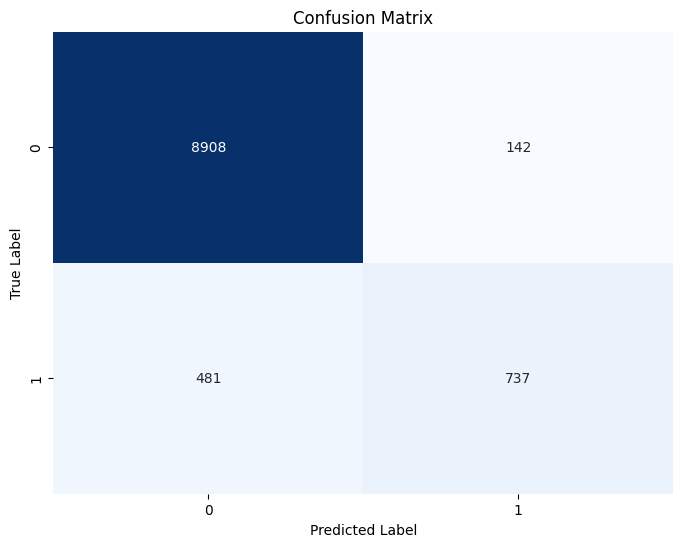

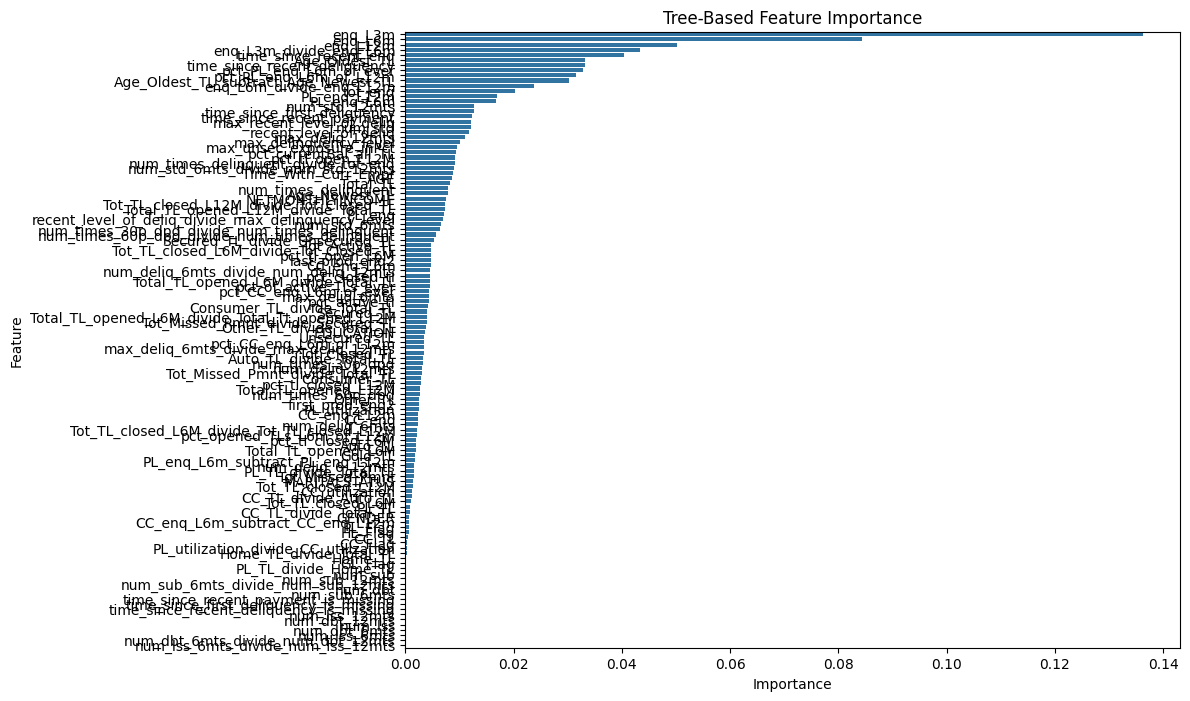

In [ ]:
f1_rf, conf_matrix_rf, df_importances_rf_label = evaluate_model(best_model, X_test_encoded, y_test, preprocessor=None, feature_names=X_train_encoded.columns)

In [ ]:
df_importances_rf_label

,Feature,Importance
0,Total_TL,0.008260
1,Tot_Closed_TL,0.003445
2,Tot_Active_TL,0.004828
3,Total_TL_opened_L6M,0.001917
4,Tot_TL_closed_L6M,0.001134
...,...,...
115,enq_L3m_divide_enq_L6m,0.043412
116,enq_L6m_divide_enq_L12m,0.023864
117,max_deliq_6mts_divide_max_deliq_12mts,0.003449
118,recent_level_of_deliq_divide_max_delinquency_l...,0.006949


In [ ]:
df_importances_rf_label.shape

(120, 2)

In [ ]:
df_importances_rf_label.to_csv(base_dir + r'/rf_importances_label.csv', index=False)

In [ ]:
X_train_label['Approved_Flag'] = y_train
X_test_label['Approved_Flag'] = y_test
# X_train_label.to_csv(base_dir + r'/train_label.csv', index=False)
# X_test_label.to_csv(base_dir + r'/test_label.csv', index=False)

,count
Approved_Flag,
0,9050
1,1218


**Logistic Regression**

In [ ]:
X_train_lr = X_train_tree.dropna(axis=1, how='any')
X_test_lr = X_test_tree.dropna(axis=1, how='any')

In [ ]:
missing_values = X_train_lr.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

Series([], dtype: int64)


**Random forest baseline**

F1: 0.7066096053257251
Confusion Matrix:


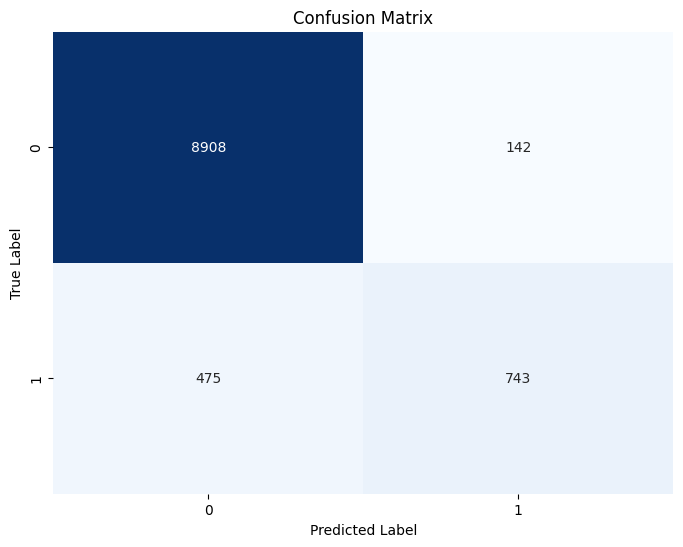

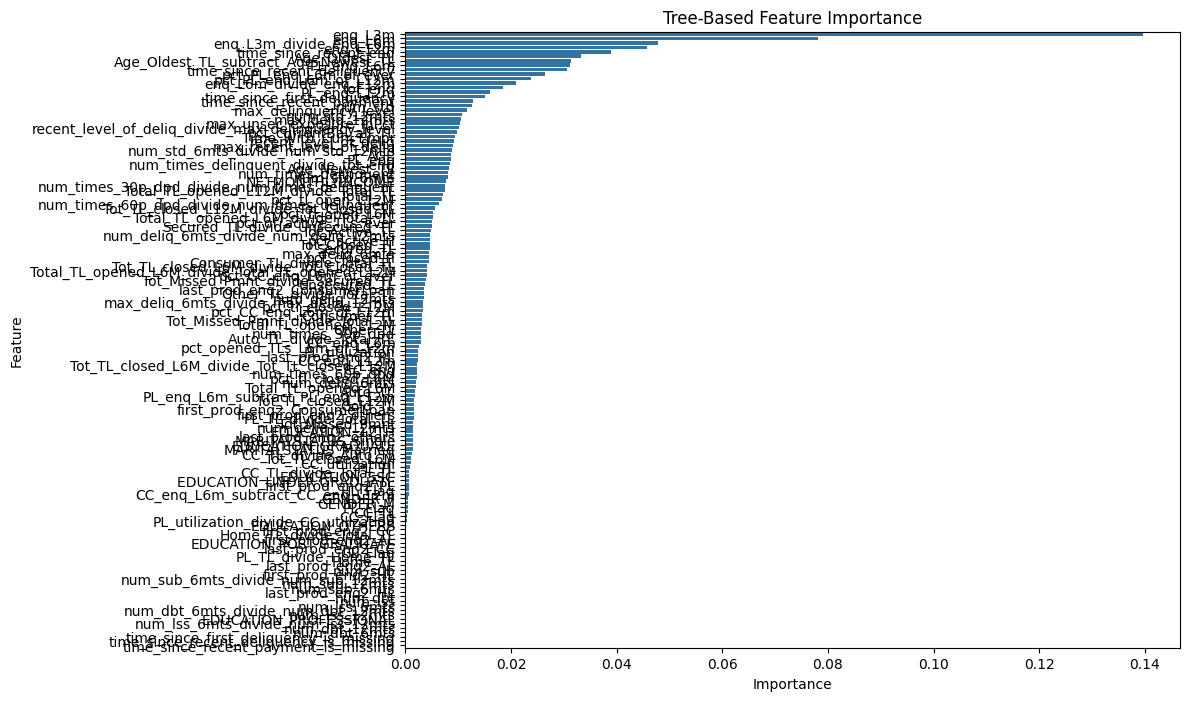

In [ ]:
# Randomized CV for fine-tuning
param_dist_rf = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10)
}


pipeline = create_model_pipeline(preprocessor=None, classifier_type='random_forest')
best_model = perform_randomized_search(pipeline, X_train_tree, y_train, param_dist_rf)

# Evaluate the best model and show feature importance
f1_rf, conf_matrix_rf, df_importances_rf = evaluate_model(best_model, X_test_tree, y_test, preprocessor=None, feature_names=X_train_tree.columns)


In [ ]:
df_importances_rf.to_csv(base_dir + r'/rf_importances.csv', index=False)

**New important feature**

enq_L3m_divide_enq_L6m
Age_Oldest_TL_sibtract_Age_Newest_TL

F1: 0.7107516650808754
Confusion Matrix:


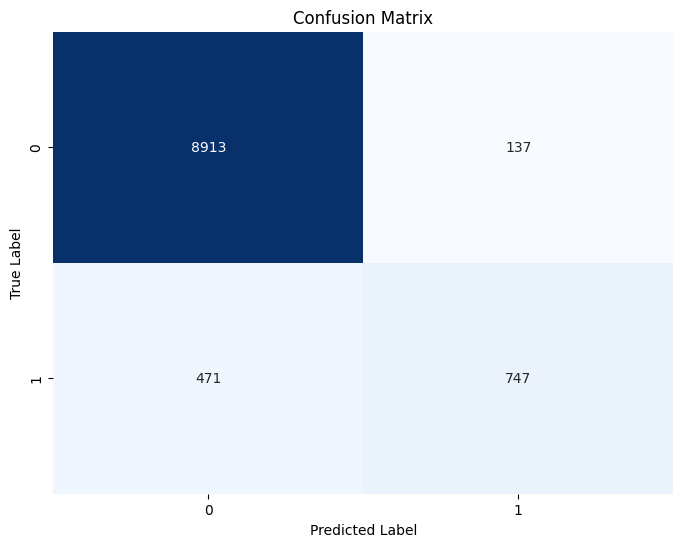

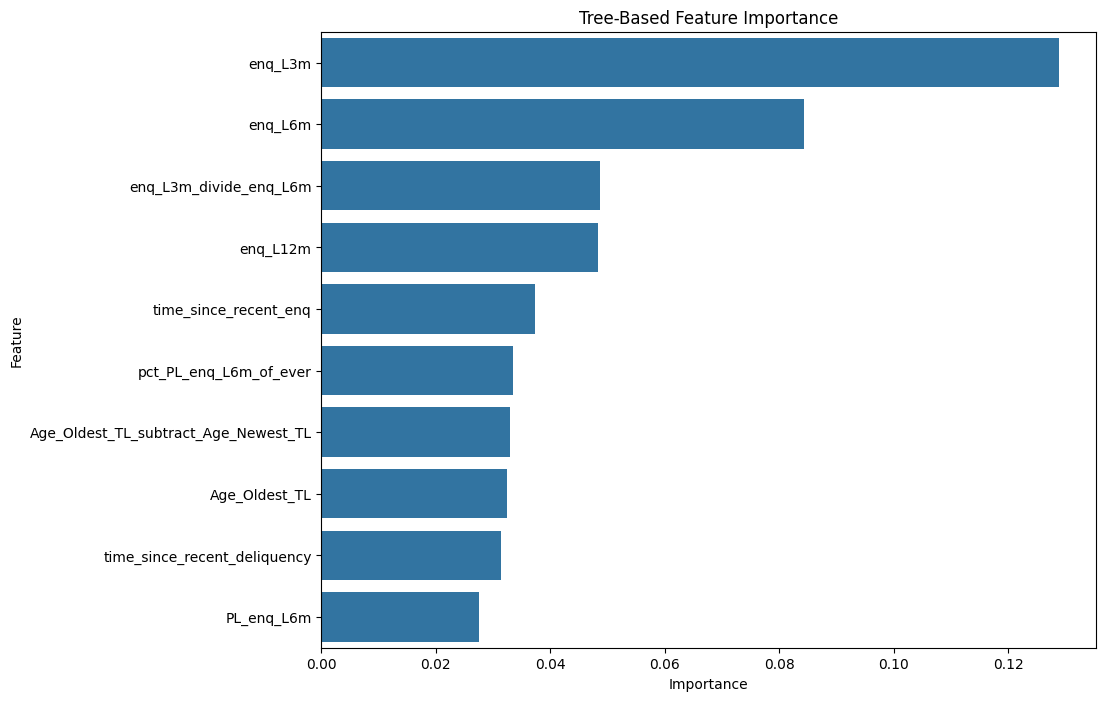

In [ ]:
X_train_tree_imp = pd.concat([X_train, X_train_encoded], axis=1)[important_features]
X_test_tree_imp = pd.concat([X_test, X_test_encoded], axis=1)[important_features]

param_dist_rf = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10)
}


pipeline = create_model_pipeline(preprocessor=None, classifier_type='random_forest')
best_model = perform_randomized_search(pipeline, X_train_tree_imp, y_train, param_dist_rf)

# Evaluate the best model and show feature importance
f1_rf_imp, conf_matrix_rf_imp, df_importances_rf_imp = evaluate_model(best_model, X_test_tree_imp, y_test, preprocessor=None, feature_names=X_train_tree_imp.columns)


**XGBoost baseline**

F1: 0.7578297309219233
Confusion Matrix:


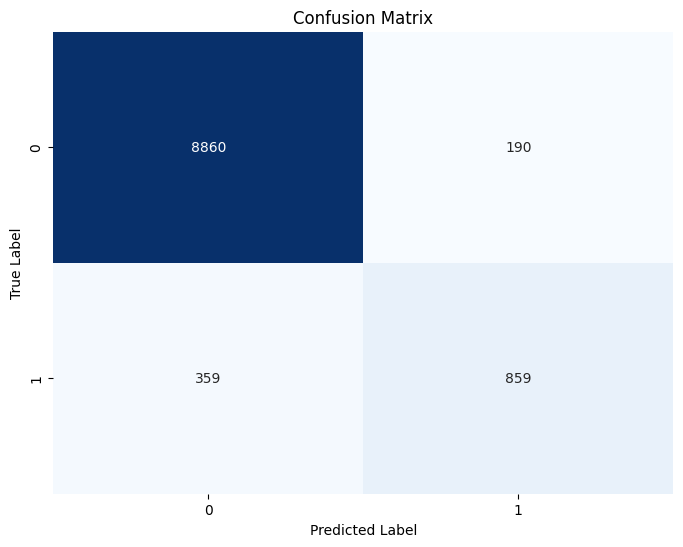

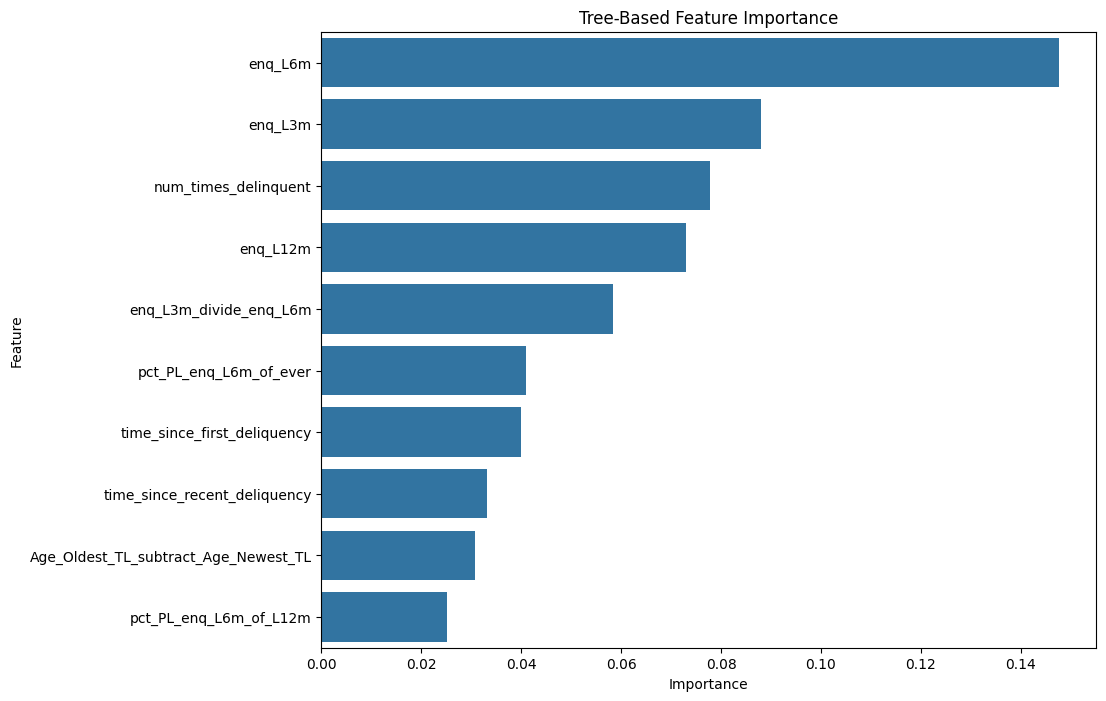

In [ ]:
param_dist_xgb = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': randint(3, 10),
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}


pipeline = create_model_pipeline(preprocessor=None, classifier_type='xgboost')
best_model = perform_randomized_search(pipeline, X_train_tree, y_train, param_dist_xgb)

f1_xgb, conf_matrix_xgb, df_importances_xgb = evaluate_model(best_model, X_test_tree, y_test, preprocessor=None, feature_names=X_train_tree.columns)

F1: 0.7543160690571049
Confusion Matrix:


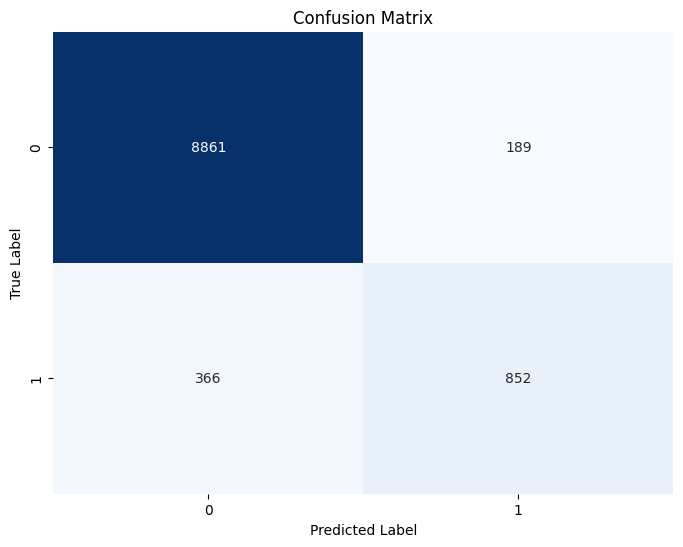

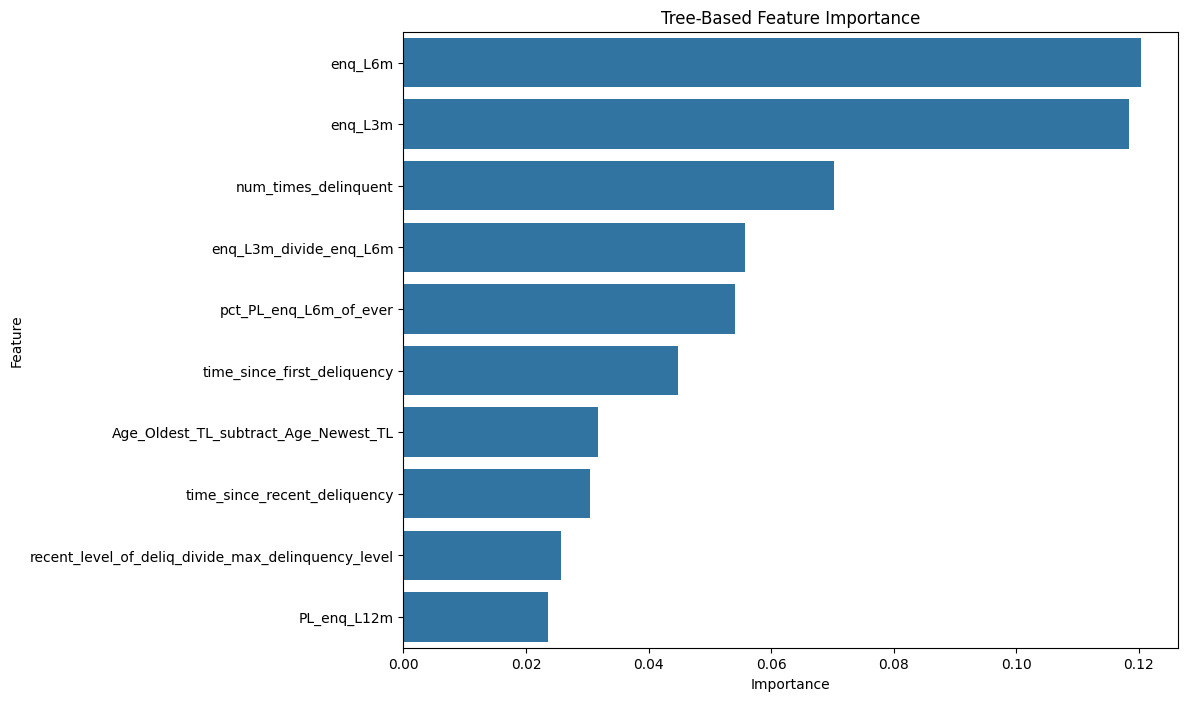

In [ ]:
param_dist_xgb = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': randint(3, 10),
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}


pipeline = create_model_pipeline(preprocessor=None, classifier_type='xgboost')
best_model = perform_randomized_search(pipeline, X_train_tree_imp, y_train, param_dist_xgb)

f1_xgb_imp, conf_matrix_xgb_imp, df_importances_xgb_imp = evaluate_model(best_model, X_test_tree_imp, y_test, preprocessor=None, feature_names=X_train_tree_imp.columns)

**Random forest with SMOTE**

F1: 0.7097858042839144
Confusion Matrix:


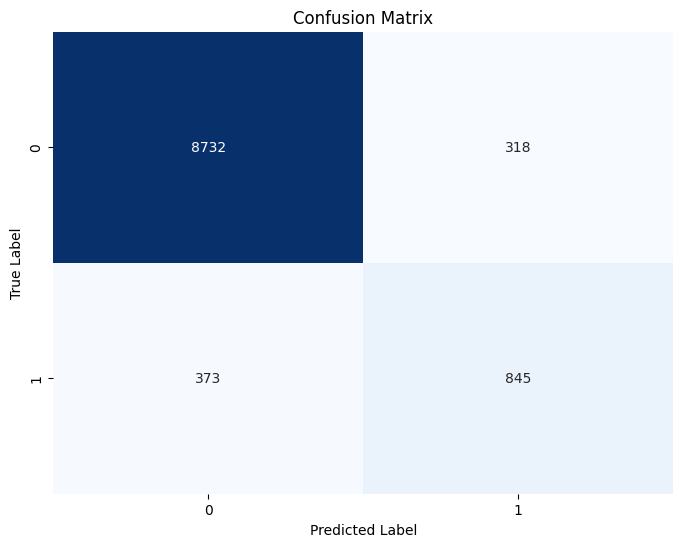

ValueError: All arrays must be of the same length

In [ ]:
smote = SMOTE(random_state=42)

# Randomized CV for Random Forest with SMOTE fine-tuning
param_dist_rf = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10)
}

pipeline = ImbPipeline(steps=[
    ('smote', smote),
    ('classifier', RandomForestClassifier(random_state=42))
])


best_model = perform_randomized_search(pipeline, X_train_lr, y_train, param_dist_rf)

# Evaluate the best model and show feature importance
f1_rf_smote, conf_matrix_rf_smote, df_importances_rf_smote = evaluate_model(best_model, X_test_lr, y_test, preprocessor=None, feature_names=X_train_tree.columns)

**Random forest with SMOTE**

In [ ]:
smote = SMOTE(random_state=42)

# Randomized CV for Random Forest with SMOTE fine-tuning
param_dist_rf = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10)
}

pipeline = ImbPipeline(steps=[
    ('smote', smote),
    ('classifier', RandomForestClassifier(random_state=42))
])


best_model = perform_randomized_search(pipeline, X_train_lr, y_train, param_dist_rf)

**Logistic regression baseline**

F1: 0.712707182320442
Confusion Matrix:


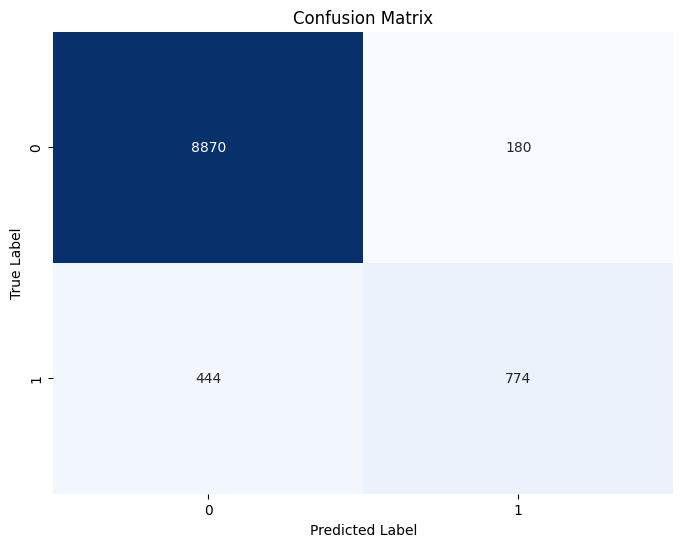

The classifier does not support feature importances.


UnboundLocalError: local variable 'feature_importance_df' referenced before assignment

In [ ]:
param_dist_lr = {
    'classifier__C': uniform(0.01, 10),  # Inverse of regularization strength
    'classifier__penalty': ['l1', 'l2'],  # Regularization types
    'classifier__solver': ['liblinear', 'saga'],  # Solvers for L1 and L2 penalties
    'classifier__max_iter': [100, 200, 300]  # Number of iterations
}

pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

best_model = perform_randomized_search(pipeline, X_train_lr, y_train, param_dist_lr)

f1_lr, conf_matrix_lr, df_importances_lr =  evaluate_model(best_model, X_test_lr, y_test, preprocessor=None, feature_names=X_train_lr.columns)

best_logistic_model = best_model.best_estimator_.named_steps['classifier']

# Get the feature names and corresponding coefficients
coefficients = best_logistic_model.coef_[0]
feature_names = X_train.columns

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coeff_df = coeff_df.reindex(coeff_df.Coefficient.abs().sort_values(ascending=False).index)

display(coeff_df)


**Decision Tree**

F1: 0.7028493894165536
Confusion Matrix:


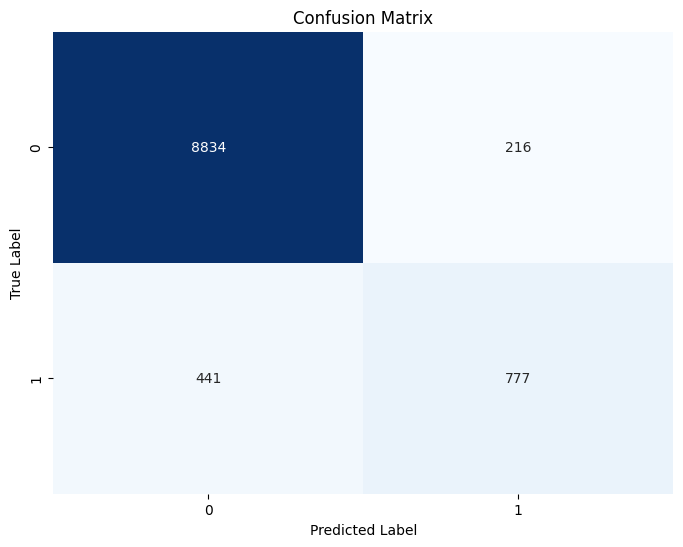

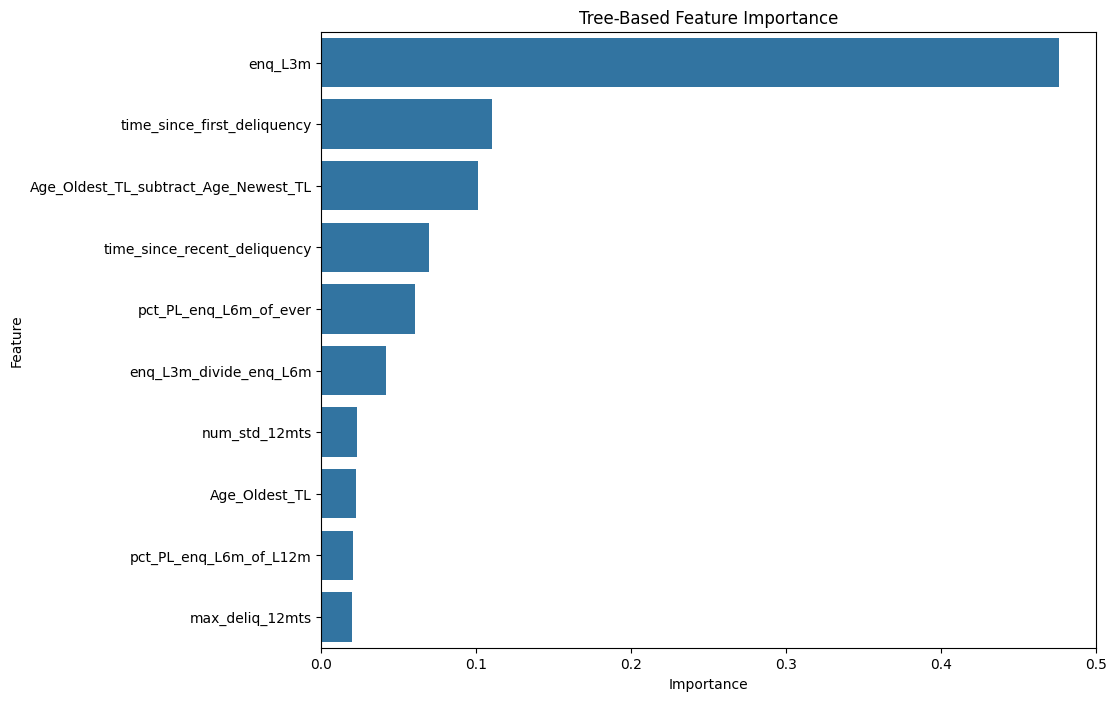

,Feature,Importance
61,enq_L3m,0.476613
26,time_since_first_deliquency,0.110244
90,Age_Oldest_TL_subtract_Age_Newest_TL,0.101072
27,time_since_recent_deliquency,0.069374
74,pct_PL_enq_L6m_of_ever,0.060180
...,...,...
44,num_dbt,0.000000
43,num_sub_12mts,0.000000
42,num_sub_6mts,0.000000
41,num_sub,0.000000


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define the hyperparameter distribution for decision tree
param_dist_dt = {
    'classifier__max_depth': randint(1, 20),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__criterion': ['gini', 'entropy'],
}


pipeline = ImbPipeline(steps=[
    ('classifier', DecisionTreeClassifier(random_state=42))
])

best_model = perform_randomized_search(pipeline, X_train, y_train, param_dist_dt)

f1_dt, conf_matrix_dt, df_importances_dt = evaluate_model(best_model, X_test, y_test, preprocessor=None, feature_names=X_train.columns)

best_decision_tree = best_model.best_estimator_.named_steps['classifier']

importances = best_decision_tree.feature_importances_
feature_names = X_train.columns


importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

display(importances_df)


RF: 0.715 (ohe), 0.702 (lable-encoding)

XGB: 0.758

Logistic Regression: 0.713

DT: 0.703


In [ ]:
X_train_before_ohe['Approved_Flag'] = y_train
X_test_before_ohe['Approved_Flag'] = y_test
# Save the combined DataFrame as a CSV file
X_train_before_ohe.to_csv(base_dir + r'/train_no_ohe.csv', index=False)
X_test_before_ohe.to_csv(base_dir + r'/test_no_ohe.csv', index=False)

X_train_tree = pd.concat([X_train_tree, y_train], axis=1)
X_test_tree = pd.concat([X_test_tree, y_test], axis-1)
X_train_tree.to_csv(base_dir + r'/train_tree.csv', index=False)
X_test_tree.to_csv(base_dir + r'/test_tree.csv', index=False)

X_train_lr['Approved_Flag'] = y_train
X_test_lr['Approved_Flag'] = y_test
X_train_lr.to_csv(base_dir + r'/train_lr.csv', index=False)
X_test_lr.to_csv(base_dir + r'/test_lr.csv', index=False)

<ipython-input-12-7d09b1041837>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_lr['Approved_Flag'] = y_train
<ipython-input-12-7d09b1041837>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_lr['Approved_Flag'] = y_test
